In [5]:
# -*- coding: utf-8 -*-
"""
MW* (Makarenkov & Lapointe, Bioinformatics 2004) baseline:
Weighted least-squares inference of phylogeny from incomplete distance matrices + patristic completion.

This script:
  - Loads an ORIGINAL complete distance matrix D0 (n x n).
  - Generates EXACT 15 masked matrices (3 missingness levels × 5 replicates).
  - Runs MW* on each mask:
      Step A: minimax Ultrametric (Table 1) OR minimax Additive (Table 2) to estimate some missing distances.
              Build weights W_ij per Eq.(8): 1 for originally known, 0.5 for Step-A estimated, 0 otherwise.
      Step B: MW* stepwise addition minimizing Qw (Eq.(4)):
              - choose next taxon by Eq.(10), ties by best achievable Qw, then Eq.(9).
              - graft by splitting each edge and selecting variant with minimal Qw.
              - exhaustive over all start pairs (i,j) with known d(i,j) in D_A.

IMPORTANT MODIFICATION (your request):
  - The final completed matrix is forced to PRESERVE ALL OBSERVED ENTRIES EXACTLY.
    That is, for every mask, if D_inc[i,j] was observed (not -1), then D_hat[i,j] == D_inc[i,j].

Evaluation harness (not part of MW* paper):
  - RMSE/MAE on all-pairs lower triangle vs original D0
  - RMSE/MAE on missing-only entries (upper triangle) vs original D0
  - Robust delta metrics: Delta_total, Delta_per_triangle, Delta_relative (vs original)

No external phylogenetic libraries.
Missing entries are encoded as -1.
"""

import os, time
import numpy as np
import pandas as pd
from itertools import combinations
from typing import List, Tuple, Dict

# ============================================================
# Config
# ============================================================
MISSING_VAL = -1.0
PRESERVE_OBSERVED_ENTRIES = True

# EXACT 15 masks = 3 missingness × 5 reps
MISSING_FRACS = (0.30, 0.50, 0.65, 0.85, 0.90)
REPS = 5
BASE_SEED = 55

# Robust delta constants
OMEGA   = 2.0
EPS_NUM = 1.0e-12

# ============================================================
# Loading & symmetry
# ============================================================
def load_matrix_with_candidates(cands: List[str]) -> Tuple[np.ndarray, str]:
    tried = []
    for p in cands:
        tried.append(p)
        if os.path.exists(p):
            return np.loadtxt(p, dtype=float), p
    raise FileNotFoundError("File not found. Tried:\n" + "\n".join(tried))

def symmetrize_full(D: np.ndarray) -> np.ndarray:
    M = 0.5 * (D + D.T)
    np.fill_diagonal(M, 0.0)
    return M

def symmetrize_with_missing(D: np.ndarray, missing_val: float = MISSING_VAL) -> np.ndarray:
    """Symmetrize partial matrix; if one side known and the other missing, keep the known."""
    M = np.array(D, dtype=float, copy=True)
    n = M.shape[0]
    np.fill_diagonal(M, 0.0)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = M[i, j], M[j, i]
            a_ok = (a != missing_val)
            b_ok = (b != missing_val)
            if a_ok and b_ok:
                v = 0.5 * (a + b)
            elif a_ok:
                v = a
            elif b_ok:
                v = b
            else:
                v = missing_val
            M[i, j] = M[j, i] = v
    np.fill_diagonal(M, 0.0)
    return M

# ============================================================
# Robust delta metrics (evaluation harness)
# ============================================================
def robust_delta_per_triplet_numpy(M: np.ndarray, triplets: np.ndarray) -> np.ndarray:
    i, j, k = triplets[:, 0], triplets[:, 1], triplets[:, 2]
    a = M[i, j]; b = M[i, k]; c = M[j, k]
    S = np.stack([a, b, c], axis=1)
    S_sorted = -np.sort(-S, axis=1)  # descending
    a, b, c = S_sorted[:, 0], S_sorted[:, 1], S_sorted[:, 2]

    viol = a >= (b + c)
    denom_v = np.maximum(b + c, EPS_NUM)
    delta1 = np.maximum(a / denom_v, OMEGA)

    denomA = np.maximum(2.0 * b * c, EPS_NUM)
    denomB = np.maximum(2.0 * a * c, EPS_NUM)
    denomG = np.maximum(2.0 * a * b, EPS_NUM)
    cosA = np.clip((b*b + c*c - a*a) / denomA, -1.0, 1.0)
    cosB = np.clip((a*a + c*c - b*b) / denomB, -1.0, 1.0)
    cosG = np.clip((a*a + b*b - c*c) / denomG, -1.0, 1.0)

    A = np.arccos(cosA); B = np.arccos(cosB); G = np.arccos(cosG)
    Ang = np.stack([A, B, G], axis=1)
    Ang_sorted = -np.sort(-Ang, axis=1)
    A, B, G = Ang_sorted[:, 0], Ang_sorted[:, 1], Ang_sorted[:, 2]
    delta2 = (A - B) / np.maximum(G, EPS_NUM)

    return np.where(viol, delta1, delta2)

def robust_delta_sum_numpy(M: np.ndarray, triplets: np.ndarray) -> float:
    return float(robust_delta_per_triplet_numpy(M, triplets).sum())

# ============================================================
# Error metrics (evaluation harness)
# ============================================================
def rmse_on_lt(A: np.ndarray, B: np.ndarray) -> float:
    n = A.shape[0]
    i_lt, j_lt = np.tril_indices(n, k=-1)
    diff = (A - B)[i_lt, j_lt]
    return float(np.sqrt(np.mean(diff * diff)))

def mae_on_lt(A: np.ndarray, B: np.ndarray) -> float:
    n = A.shape[0]
    i_lt, j_lt = np.tril_indices(n, k=-1)
    diff = np.abs((A - B)[i_lt, j_lt])
    return float(np.mean(diff))

def rmse_on_mask_upper(A: np.ndarray, B: np.ndarray, mask_upper: np.ndarray) -> float:
    n = A.shape[0]
    iu, ju = np.triu_indices(n, k=1)
    sel = mask_upper[iu, ju]
    if np.sum(sel) == 0:
        return float("nan")
    diff = (A - B)[iu[sel], ju[sel]]
    return float(np.sqrt(np.mean(diff * diff)))

def mae_on_mask_upper(A: np.ndarray, B: np.ndarray, mask_upper: np.ndarray) -> float:
    n = A.shape[0]
    iu, ju = np.triu_indices(n, k=1)
    sel = mask_upper[iu, ju]
    if np.sum(sel) == 0:
        return float("nan")
    diff = np.abs((A - B)[iu[sel], ju[sel]])
    return float(np.mean(diff))

# ============================================================
# Mask generation (reproducible harness)
# ============================================================
def simulate_missing(D_full: np.ndarray, frac_missing: float, rng: np.random.RandomState, missing_val: float = MISSING_VAL):
    """Mask a fraction of lower-triangle pairs to missing_val and mirror symmetrically. DOES NOT modify D_full."""
    n = D_full.shape[0]
    lower = np.tril(np.ones((n, n), dtype=bool), k=-1)
    I, J = np.where(lower)
    m = len(I)
    drop = int(round(frac_missing * m))

    keep = np.ones(m, dtype=bool)
    if drop > 0:
        keep[rng.choice(m, size=drop, replace=False)] = False

    D_inc = np.array(D_full, dtype=float, copy=True)
    for idx in range(m):
        if not keep[idx]:
            i, j = I[idx], J[idx]
            D_inc[i, j] = D_inc[j, i] = missing_val

    D_inc = symmetrize_with_missing(D_inc, missing_val=missing_val)
    obs_mask = (D_inc != missing_val)
    np.fill_diagonal(obs_mask, True)
    return D_inc, obs_mask

# ============================================================
# Step A (MW*): minimax Ultrametric / Additive procedures
# ============================================================
def choose_stepA_method_thresholds(n: int, frac_missing: float) -> str:
    """
    Thresholds stated in the 2004 paper text:
      8x8:  Additive if <20% missing else Ultrametric
      16x16: Additive if <30% missing else Ultrametric
      24x24: Additive if <40% missing else Ultrametric
    """
    if n <= 8:
        thr = 0.20
    elif n <= 16:
        thr = 0.30
    elif n <= 24:
        thr = 0.40
    else:
        thr = 0.40
    return "additive" if frac_missing < thr else "ultrametric"

def ultrametric_minimax_table1(D_partial: np.ndarray, missing_val: float = MISSING_VAL, max_loops: int = 10_000):
    """
    Table 1: d(i,j) := min_k max(d(i,k), d(j,k)) for missing entries, iterate until no change.
    Does NOT overwrite known entries.
    """
    D = symmetrize_with_missing(D_partial, missing_val=missing_val)
    n = D.shape[0]
    missing0 = (D == missing_val) & (~np.eye(n, dtype=bool))
    est_mask = np.zeros_like(D, dtype=bool)

    loops = 0
    while loops < max_loops:
        loops += 1
        changed = False
        for i in range(n):
            for j in range(i + 1, n):
                if D[i, j] != missing_val:
                    continue
                best = None
                for k in range(n):
                    if k == i or k == j:
                        continue
                    dik, djk = D[i, k], D[j, k]
                    if dik == missing_val or djk == missing_val:
                        continue
                    cand = max(dik, djk)
                    if (best is None) or (cand < best):
                        best = cand
                if best is not None:
                    D[i, j] = D[j, i] = float(best)
                    est_mask[i, j] = est_mask[j, i] = True
                    changed = True
        if not changed:
            break

    filled = missing0 & (D != missing_val)
    est_mask = est_mask & filled
    return D, est_mask

def additive_minimax_table2(D_partial: np.ndarray, missing_val: float = MISSING_VAL, max_loops: int = 10_000):
    """
    Table 2: d(i,j) := min_{k,l} [ max(d(i,k)+d(j,l), d(i,l)+d(j,k)) - d(k,l) ], iterate until no change.
    Does NOT overwrite known entries.
    """
    D = symmetrize_with_missing(D_partial, missing_val=missing_val)
    n = D.shape[0]
    missing0 = (D == missing_val) & (~np.eye(n, dtype=bool))
    est_mask = np.zeros_like(D, dtype=bool)

    loops = 0
    while loops < max_loops:
        loops += 1
        changed = False
        for i in range(n):
            for j in range(i + 1, n):
                if D[i, j] != missing_val:
                    continue
                best = None
                for k in range(n):
                    if k == i or k == j:
                        continue
                    dik, djk = D[i, k], D[j, k]
                    if dik == missing_val or djk == missing_val:
                        continue
                    for l in range(n):
                        if l == i or l == j or l == k:
                            continue
                        dil, djl, dkl = D[i, l], D[j, l], D[k, l]
                        if dil == missing_val or djl == missing_val or dkl == missing_val:
                            continue
                        cand = max(dik + djl, dil + djk) - dkl
                        if (best is None) or (cand < best):
                            best = cand
                if best is not None:
                    D[i, j] = D[j, i] = float(best)
                    est_mask[i, j] = est_mask[j, i] = True
                    changed = True
        if not changed:
            break

    filled = missing0 & (D != missing_val)
    est_mask = est_mask & filled
    return D, est_mask

def mw_star_stepA_build_D_and_W(D_inc: np.ndarray, obs_mask_initial: np.ndarray, frac_missing: float, missing_val: float = MISSING_VAL):
    """
    Step A:
      - run minimax ultrametric or additive completion
      - build weights W_ij per Eq.(8): 1 (originally known), 0.5 (estimated), 0 (otherwise)
    """
    D0p = symmetrize_with_missing(D_inc, missing_val=missing_val)
    n = D0p.shape[0]

    method = choose_stepA_method_thresholds(n, frac_missing)
    if method == "ultrametric":
        D_A, est_mask = ultrametric_minimax_table1(D0p, missing_val=missing_val)
    else:
        D_A, est_mask = additive_minimax_table2(D0p, missing_val=missing_val)

    known0 = obs_mask_initial.copy()
    np.fill_diagonal(known0, True)
    known0 = known0 & (~np.eye(n, dtype=bool))

    W = np.zeros((n, n), dtype=float)
    W[known0] = 1.0
    W[est_mask] = 0.5
    np.fill_diagonal(W, 0.0)
    W = 0.5 * (W + W.T)

    D_A = symmetrize_with_missing(D_A, missing_val=missing_val)
    np.fill_diagonal(D_A, 0.0)
    return D_A, W, method

# ============================================================
# Tree representation utilities (undirected)
# ============================================================
def build_edge_index(edges_uv: List[Tuple[int, int]]):
    edge_map = {}
    edges2 = []
    eid = 0
    for (u, v) in edges_uv:
        key = (u, v) if u < v else (v, u)
        if key in edge_map:
            continue
        edge_map[key] = eid
        edges2.append((u, v, eid))
        eid += 1
    return edges2, edge_map

def build_adjacency(edges: List[Tuple[int, int, int]]) -> Dict[int, List[Tuple[int, int]]]:
    adj: Dict[int, List[Tuple[int, int]]] = {}
    for u, v, eid in edges:
        adj.setdefault(u, []).append((v, eid))
        adj.setdefault(v, []).append((u, eid))
    return adj

def path_edge_ids(adj: Dict[int, List[Tuple[int, int]]], src: int, dst: int) -> List[int]:
    """Find unique path in a TREE from src to dst; return edge_id list."""
    q = [src]
    parent = {src: (-1, -1)}  # node -> (prev_node, edge_id)
    head = 0
    while head < len(q):
        x = q[head]
        head += 1
        if x == dst:
            break
        for y, eid in adj.get(x, []):
            if y in parent:
                continue
            parent[y] = (x, eid)
            q.append(y)
    if dst not in parent:
        raise RuntimeError("Tree path not found.")
    eids = []
    cur = dst
    while cur != src:
        prev, eid = parent[cur]
        eids.append(eid)
        cur = prev
    eids.reverse()
    return eids

def patristic_matrix_from_tree(n_leaves: int, edges: List[Tuple[int, int, int]], lengths: np.ndarray) -> np.ndarray:
    """All-pairs leaf distances on a tree with given edge lengths."""
    adj = build_adjacency(edges)
    elen = {eid: float(lengths[eid]) for _, _, eid in edges}

    D = np.zeros((n_leaves, n_leaves), dtype=float)
    for i in range(n_leaves):
        for j in range(i + 1, n_leaves):
            eids = path_edge_ids(adj, i, j)
            D[i, j] = D[j, i] = sum(elen[eid] for eid in eids)
    np.fill_diagonal(D, 0.0)
    return D

# ============================================================
# NNLS (Lawson–Hanson) for nonnegative branch lengths
# ============================================================
def nnls_lawson_hanson(A: np.ndarray, b: np.ndarray, tol: float = 1e-12, max_iter: int = None) -> np.ndarray:
    """Solve min ||A x - b||_2 subject to x >= 0 using Lawson–Hanson active set."""
    m, n = A.shape
    if max_iter is None:
        max_iter = 30 * n

    x = np.zeros(n, dtype=float)
    P = np.zeros(n, dtype=bool)   # passive set
    Z = ~P                        # active set

    def lsq_on_passive(Pmask: np.ndarray) -> np.ndarray:
        if not np.any(Pmask):
            return np.zeros(n, dtype=float)
        Ap = A[:, Pmask]
        zp, *_ = np.linalg.lstsq(Ap, b, rcond=None)
        z = np.zeros(n, dtype=float)
        z[Pmask] = zp
        return z

    w = A.T @ (b - A @ x)
    it = 0
    while np.any(Z) and (np.max(w[Z]) > tol) and (it < max_iter):
        t = np.argmax(np.where(Z, w, -np.inf))
        P[t] = True
        Z[t] = False

        while True:
            z = lsq_on_passive(P)
            if np.all(z[P] > tol):
                x = z
                break

            x_old = x.copy()
            negP = P & (z <= tol)
            if not np.any(negP):
                x = np.maximum(z, 0.0)
                break

            alphas = []
            for i0 in np.where(negP)[0]:
                if x_old[i0] > 0:
                    alphas.append(x_old[i0] / (x_old[i0] - z[i0]))
            alpha = min(alphas) if alphas else 0.0

            x = x_old + alpha * (z - x_old)

            toZ = P & (x <= tol)
            P[toZ] = False
            Z[toZ] = True
            x[toZ] = 0.0

        w = A.T @ (b - A @ x)
        it += 1

    return np.maximum(x, 0.0)

# ============================================================
# Weighted least squares for fixed topology: minimize Qw (Eq.(4))
# ============================================================
def fit_branch_lengths_min_Qw(
    edges_uv: List[Tuple[int, int]],
    D_A: np.ndarray,
    W: np.ndarray,
    leaf_set: List[int],
    missing_val: float = MISSING_VAL
) -> Tuple[np.ndarray, float]:
    """
    min_{x>=0} sum_{i<j in leaf_set} W_ij * (d_T(i,j;x) - D_A(i,j))^2
    using NNLS on weighted design matrix.
    """
    edges, _ = build_edge_index(edges_uv)
    adj = build_adjacency(edges)
    m_edges = max(eid for _, _, eid in edges) + 1

    L = sorted(leaf_set)
    pairs = []
    for a in range(len(L)):
        i = L[a]
        for b in range(a + 1, len(L)):
            j = L[b]
            wij = float(W[i, j])
            dij = float(D_A[i, j])
            if wij <= 0.0:
                continue
            if dij == missing_val:
                continue
            pairs.append((i, j, wij, dij))

    Pn = len(pairs)
    if Pn == 0:
        return np.zeros(m_edges, dtype=float), 0.0

    A = np.zeros((Pn, m_edges), dtype=float)
    y = np.zeros(Pn, dtype=float)
    wvec = np.zeros(Pn, dtype=float)

    for p, (i, j, wij, dij) in enumerate(pairs):
        eids = path_edge_ids(adj, i, j)
        A[p, eids] = 1.0
        y[p] = dij
        wvec[p] = wij

    sw = np.sqrt(np.maximum(wvec, 0.0))
    Aw = A * sw[:, None]
    yw = y * sw

    x = nnls_lawson_hanson(Aw, yw, tol=1e-12)
    resid = Aw @ x - yw
    Qw = float(resid @ resid)
    return x, Qw

# ============================================================
# Step B (MW*): stepwise addition minimizing Qw
# ============================================================
def global_score_eq9(W: np.ndarray) -> np.ndarray:
    """Eq.(9) style global score: Score(k,X)=sum_{l in X} w(l,k). Here we use total weights per node."""
    return np.sum(W, axis=0)

def best_graft_for_candidate(
    cand: int,
    edges_uv: List[Tuple[int, int]],
    next_internal_id: int,
    D_A: np.ndarray,
    W: np.ndarray,
    leaf_set_current: List[int],
    missing_val: float = MISSING_VAL
) -> Tuple[List[Tuple[int, int]], np.ndarray, float]:
    """
    Try grafting cand by splitting each existing edge (a,b):
      remove (a,b), add (a,u),(u,b),(u,cand), u=next_internal_id.
    Evaluate Qw over leaf_set_current ∪ {cand}.
    """
    leaf_set_new = list(leaf_set_current) + [cand]

    if len(edges_uv) == 0:
        u = next_internal_id
        variant = [(leaf_set_current[0], u), (u, cand)]
        x, Qw = fit_branch_lengths_min_Qw(variant, D_A, W, leaf_set_new, missing_val=missing_val)
        return variant, x, Qw

    best_edges = None
    best_x = None
    best_Qw = None

    for (a, b) in edges_uv:
        u = next_internal_id
        variant = []
        for (x0, y0) in edges_uv:
            if (x0 == a and y0 == b) or (x0 == b and y0 == a):
                continue
            variant.append((x0, y0))
        variant.extend([(a, u), (u, b), (u, cand)])

        xlen, Qw = fit_branch_lengths_min_Qw(variant, D_A, W, leaf_set_new, missing_val=missing_val)
        if (best_Qw is None) or (Qw < best_Qw - 1e-15):
            best_Qw = Qw
            best_edges = variant
            best_x = xlen

    return best_edges, best_x, float(best_Qw)

def select_next_taxon(
    leaves_in_tree: List[int],
    remaining: List[int],
    W: np.ndarray,
    D_A: np.ndarray,
    edges_uv: List[Tuple[int, int]],
    next_internal_id: int,
    score_global: np.ndarray,
    missing_val: float = MISSING_VAL
) -> int:
    """
    Eq.(10): choose candidate maximizing sum_{l in current leaves} w(l, cand).
    Tie-break 1: minimal best-achievable Qw after optimal grafting.
    Tie-break 2: maximal global score (Eq.(9)-style).
    Final deterministic: smallest index.
    """
    L = list(leaves_in_tree)

    prim = [(float(np.sum(W[L, cand])), cand) for cand in remaining]
    max_s = max(s for s, _ in prim)
    cands1 = [cand for s, cand in prim if abs(s - max_s) < 1e-12]
    if len(cands1) == 1:
        return cands1[0]

    bestQ = {}
    for cand in cands1:
        _, _, q = best_graft_for_candidate(
            cand=cand,
            edges_uv=edges_uv,
            next_internal_id=next_internal_id,
            D_A=D_A,
            W=W,
            leaf_set_current=L,
            missing_val=missing_val
        )
        bestQ[cand] = q
    minQ = min(bestQ.values())
    cands2 = [c for c in cands1 if abs(bestQ[c] - minQ) < 1e-12]
    if len(cands2) == 1:
        return cands2[0]

    gs = [(float(score_global[c]), c) for c in cands2]
    maxg = max(v for v, _ in gs)
    cands3 = [c for v, c in gs if abs(v - maxg) < 1e-12]
    return min(cands3)

def mw_star_stepB_build_tree(
    D_A: np.ndarray,
    W: np.ndarray,
    missing_val: float = MISSING_VAL,
    exhaustive_start_pairs: bool = True
) -> Tuple[List[Tuple[int, int, int]], np.ndarray, float]:
    """
    Build MW* tree by stepwise addition minimizing Qw.
    Uses exhaustive start pairs (i,j) with known d(i,j) in D_A if enabled.
    Returns (edges_with_eid, lengths, best_Qw).
    """
    n = D_A.shape[0]
    score_g = global_score_eq9(W)

    start_pairs = [(i, j) for i in range(n) for j in range(i + 1, n) if D_A[i, j] != missing_val]
    if len(start_pairs) == 0:
        raise RuntimeError("MW*: no known distances after Step A; cannot start Step B.")

    if not exhaustive_start_pairs:
        start_pairs = [start_pairs[0]]

    best_final = None  # (Qw, edges, lengths)

    for (i0, j0) in start_pairs:
        edges_uv = [(i0, j0)]
        leaves_in_tree = [i0, j0]
        remaining = [k for k in range(n) if k not in (i0, j0)]
        next_internal = n  # internal node ids start at n

        while remaining:
            cand = select_next_taxon(
                leaves_in_tree=leaves_in_tree,
                remaining=remaining,
                W=W,
                D_A=D_A,
                edges_uv=edges_uv,
                next_internal_id=next_internal,
                score_global=score_g,
                missing_val=missing_val
            )
            edges_uv, _, _ = best_graft_for_candidate(
                cand=cand,
                edges_uv=edges_uv,
                next_internal_id=next_internal,
                D_A=D_A,
                W=W,
                leaf_set_current=leaves_in_tree,
                missing_val=missing_val
            )
            next_internal += 1
            leaves_in_tree.append(cand)
            remaining.remove(cand)

        lengths, Qw = fit_branch_lengths_min_Qw(edges_uv, D_A, W, leaf_set=list(range(n)), missing_val=missing_val)
        edges, _ = build_edge_index(edges_uv)

        if (best_final is None) or (Qw < best_final[0] - 1e-15):
            best_final = (Qw, edges, lengths)

    Qw_best, edges_best, lengths_best = best_final
    return edges_best, lengths_best, float(Qw_best)

# ============================================================
# Preserve observed entries exactly (your requirement)
# ============================================================
def project_preserve_observed(D_completed: np.ndarray, D_inc: np.ndarray, obs_mask: np.ndarray) -> np.ndarray:
    """
    Force D_out[i,j] = D_inc[i,j] for all observed entries (obs_mask True).
    Missing entries stay as in D_completed.
    """
    D_out = np.array(D_completed, dtype=float, copy=True)
    D_out[obs_mask] = D_inc[obs_mask]
    D_out = symmetrize_full(D_out)  # safe: if already symmetric, no change
    return D_out

# ============================================================
# Full MW* completion for one incomplete matrix
# ============================================================
def mw_star_completion(
    D_inc: np.ndarray,
    obs_mask_initial: np.ndarray,
    frac_missing: float,
    missing_val: float = MISSING_VAL,
    preserve_observed: bool = PRESERVE_OBSERVED_ENTRIES
) -> Tuple[np.ndarray, str]:
    """
    Full MW*:
      Step A -> (D_A, W)
      Step B -> tree minimizing Qw
      Output -> patristic distances (complete)
      Post-step -> (optional) preserve observed entries exactly (hard constraint)
    """
    D_A, W, method = mw_star_stepA_build_D_and_W(D_inc, obs_mask_initial, frac_missing, missing_val=missing_val)
    edges, lengths, _ = mw_star_stepB_build_tree(D_A, W, missing_val=missing_val, exhaustive_start_pairs=True)
    D_pat = patristic_matrix_from_tree(D_A.shape[0], edges, lengths)

    if preserve_observed:
        D_hat = project_preserve_observed(D_pat, D_inc, obs_mask_initial)
    else:
        D_hat = D_pat

    return D_hat, method

# ============================================================
# MAIN FLOW
# ============================================================
# Load ORIGINAL (never modified)
D_orig, used_orig_path = load_matrix_with_candidates([
    "Result_NW_15x15.txt",
    "/content/drive/MyDrive/Colab Notebooks/phylogenyalg/Result_NW_20x20.txt",
    "./Result_NW_15x15.txt",
    "./Result_NW_20x20.txt",
    "/mnt/data/Result_NW_15x15.txt",
    "/mnt/data/Result_NW_20x20.txt"
])

D0 = symmetrize_full(D_orig)
n = D0.shape[0]
labels = [f"T{i+1}" for i in range(n)]

# Triplets for delta metrics
trip_all = np.array(list(combinations(range(n), 3)), dtype=np.int32)
ntri = n * (n - 1) * (n - 2) // 6
Delta_original = robust_delta_sum_numpy(D0, trip_all)

print(f"Loaded original from: {used_orig_path}")
print(f"n = {n}")
print("=== Delta for original matrix ===")
print(f"Delta_original_total        = {Delta_original:.6f}")
print(f"Delta_original_per_triangle = {Delta_original / ntri:.6f}")
print(f"Triplets C(n,3)             = {ntri}")
print(f"Preserve observed entries   = {PRESERVE_OBSERVED_ENTRIES}")

# Build EXACT 15 masked matrices (3 levels × 5 reps)
masked_registry = []
for frac in MISSING_FRACS:
    for r in range(1, REPS + 1):
        rng = np.random.RandomState(BASE_SEED + (r - 1))
        D_inc, obs_mask = simulate_missing(D0, frac, rng, missing_val=MISSING_VAL)
        masked_registry.append({"frac": frac, "rep": r, "D_inc": D_inc, "obs_mask": obs_mask})

# Save masked matrices
masked_dir = "mwstar_missing_matrices"
os.makedirs(masked_dir, exist_ok=True)
for rec in masked_registry:
    pct = int(round(100 * rec["frac"]))
    fn = f"missing_p{pct}_rep{rec['rep']}.csv"
    pd.DataFrame(rec["D_inc"], index=labels, columns=labels).to_csv(os.path.join(masked_dir, fn))

# Run MW* on ALL 15
print("\n=== Running MW* completion on all masks ===")
results = []
completed_dir = "mwstar_completed_matrices_preserveobs" if PRESERVE_OBSERVED_ENTRIES else "mwstar_completed_matrices"
os.makedirs(completed_dir, exist_ok=True)

for rec in masked_registry:
    frac = rec["frac"]
    rep  = rec["rep"]
    D_inc = rec["D_inc"]
    Mobs  = rec["obs_mask"]
    pct = int(round(100 * frac))

    print(f"  Processing {pct}% missing, replicate {rep}...")

    t0 = time.perf_counter()
    D_hat, stepA_method = mw_star_completion(D_inc, Mobs, frac_missing=frac, missing_val=MISSING_VAL, preserve_observed=PRESERVE_OBSERVED_ENTRIES)
    t1 = time.perf_counter()
    runtime_sec = t1 - t0

    # Hard check: observed entries are identical (should be 0 if preserve_observed=True)
    if PRESERVE_OBSERVED_ENTRIES:
        max_abs_change = float(np.max(np.abs(D_hat[Mobs] - D_inc[Mobs])))
        if max_abs_change > 0.0:
            raise RuntimeError(f"Observed entries changed! max|diff|={max_abs_change:e}")

    # Metrics
    rmse_all = rmse_on_lt(D_hat, D0)
    mae_all  = mae_on_lt(D_hat, D0)

    miss_upper = (~Mobs) & np.triu(np.ones((n, n), dtype=bool), k=1)
    rmse_miss = rmse_on_mask_upper(D_hat, D0, miss_upper)
    mae_miss  = mae_on_mask_upper(D_hat, D0, miss_upper)

    Delta_total = robust_delta_sum_numpy(D_hat, trip_all)
    Delta_per_triangle = Delta_total / ntri
    Delta_relative = (Delta_total / Delta_original) if (Delta_original > 0) else float("nan")

    # Save completed
    fn = f"MWstar_completed_p{pct}_rep{rep}.csv"
    pd.DataFrame(D_hat, index=labels, columns=labels).to_csv(os.path.join(completed_dir, fn))

    results.append({
        "pct_missing": pct,
        "replicate": rep,
        "stepA_method": stepA_method,
        "RMSE_all_pairs": rmse_all,
        "MAE_all_pairs": mae_all,
        "RMSE_missing_only": rmse_miss,
        "MAE_missing_only": mae_miss,
        "Delta_total": Delta_total,
        "Delta_per_triangle": Delta_per_triangle,
        "Delta_relative": Delta_relative,
        "runtime_seconds": runtime_sec,
        "completed_file": fn
    })

results_df = pd.DataFrame(results)

print("\n=== MW* results (all 15 masks) ===")
try:
    from IPython.display import display
    display(results_df)
except Exception:
    print(results_df.to_string(index=False))

detailed_csv = "mwstar_all_masks_detailed_preserveobs.csv" if PRESERVE_OBSERVED_ENTRIES else "mwstar_all_masks_detailed.csv"
results_df.to_csv(detailed_csv, index=False)

# Summary (mean ± std over reps per missingness)
summary_rows = []
for frac in MISSING_FRACS:
    pct = int(round(100 * frac))
    sub = results_df[results_df["pct_missing"] == pct]

    def ms(col):
        v = sub[col].values.astype(float)
        mean = float(np.nanmean(v))
        std  = float(np.nanstd(v, ddof=1)) if len(v) > 1 else 0.0
        return mean, std

    rmse_all_m, rmse_all_s = ms("RMSE_all_pairs")
    mae_all_m,  mae_all_s  = ms("MAE_all_pairs")
    rmse_m_m,   rmse_m_s   = ms("RMSE_missing_only")
    mae_m_m,    mae_m_s    = ms("MAE_missing_only")
    dt_m,       dt_s       = ms("Delta_total")
    dp_m,       dp_s       = ms("Delta_per_triangle")
    dr_m,       dr_s       = ms("Delta_relative")
    rt_m,       rt_s       = ms("runtime_seconds")

    # Most common Step-A method for this pct (typically deterministic)
    stepA_mode = sub["stepA_method"].mode().iloc[0] if len(sub) > 0 else ""

    summary_rows.append({
        "% Missing": f"{pct}%",
        "StepA_method": stepA_mode,
        "RMSE_all_mean": rmse_all_m, "RMSE_all_std": rmse_all_s,
        "MAE_all_mean": mae_all_m,   "MAE_all_std": mae_all_s,
        "RMSE_missing_mean": rmse_m_m, "RMSE_missing_std": rmse_m_s,
        "MAE_missing_mean": mae_m_m,   "MAE_missing_std": mae_m_s,
        "Delta_total_mean": dt_m, "Delta_total_std": dt_s,
        "Delta_per_triangle_mean": dp_m, "Delta_per_triangle_std": dp_s,
        "Delta_relative_mean": dr_m, "Delta_relative_std": dr_s,
        "runtime_seconds_mean": rt_m, "runtime_seconds_std": rt_s
    })

summary_df = pd.DataFrame(summary_rows)

def fmt_pm(mean_val, std_val, decimals=6):
    return f"{mean_val:.{decimals}f} ± {std_val:.{decimals}f}"

formatted = pd.DataFrame({
    "% Missing": summary_df["% Missing"],
    "StepA_method": summary_df["StepA_method"],
    "RMSE_all": [fmt_pm(m, s, 6) for m, s in zip(summary_df["RMSE_all_mean"], summary_df["RMSE_all_std"])],
    "MAE_all":  [fmt_pm(m, s, 6) for m, s in zip(summary_df["MAE_all_mean"],  summary_df["MAE_all_std"])],
    "RMSE_missing": [fmt_pm(m, s, 6) for m, s in zip(summary_df["RMSE_missing_mean"], summary_df["RMSE_missing_std"])],
    "MAE_missing":  [fmt_pm(m, s, 6) for m, s in zip(summary_df["MAE_missing_mean"],  summary_df["MAE_missing_std"])],
    "Delta_total": [fmt_pm(m, s, 6) for m, s in zip(summary_df["Delta_total_mean"], summary_df["Delta_total_std"])],
    "Delta_per_triangle": [fmt_pm(m, s, 8) for m, s in zip(summary_df["Delta_per_triangle_mean"], summary_df["Delta_per_triangle_std"])],
    "Delta_relative": [fmt_pm(m, s, 8) for m, s in zip(summary_df["Delta_relative_mean"], summary_df["Delta_relative_std"])],
    "runtime_s": [fmt_pm(m, s, 4) for m, s in zip(summary_df["runtime_seconds_mean"], summary_df["runtime_seconds_std"])],
})

print("\n=== MW* summary (mean ± std over 5 replicates) ===")
try:
    from IPython.display import display
    display(formatted)
except Exception:
    print(formatted.to_string(index=False))

formatted_csv = "mwstar_summary_formatted_preserveobs.csv" if PRESERVE_OBSERVED_ENTRIES else "mwstar_summary_formatted.csv"
numeric_csv   = "mwstar_summary_numeric_preserveobs.csv" if PRESERVE_OBSERVED_ENTRIES else "mwstar_summary_numeric.csv"
formatted.to_csv(formatted_csv, index=False)
summary_df.to_csv(numeric_csv, index=False)

print("\n=== ALL PROCESSING COMPLETE! ===")
print("Output files:")
print(f"  - Masked matrices saved to: {masked_dir}/")
print(f"  - Completed matrices saved to: {completed_dir}/")
print(f"  - Detailed results: {detailed_csv}")
print(f"  - Summary formatted: {formatted_csv}")
print(f"  - Summary numeric: {numeric_csv}")


Loaded original from: Result_NW_15x15.txt
n = 15
=== Delta for original matrix ===
Delta_original_total        = 105.560271
Delta_original_per_triangle = 0.232001
Triplets C(n,3)             = 455
Preserve observed entries   = True

=== Running MW* completion on all masks ===
  Processing 30% missing, replicate 1...
  Processing 30% missing, replicate 2...
  Processing 30% missing, replicate 3...
  Processing 30% missing, replicate 4...
  Processing 30% missing, replicate 5...
  Processing 50% missing, replicate 1...
  Processing 50% missing, replicate 2...
  Processing 50% missing, replicate 3...
  Processing 50% missing, replicate 4...
  Processing 50% missing, replicate 5...
  Processing 65% missing, replicate 1...
  Processing 65% missing, replicate 2...
  Processing 65% missing, replicate 3...
  Processing 65% missing, replicate 4...
  Processing 65% missing, replicate 5...
  Processing 85% missing, replicate 1...
  Processing 85% missing, replicate 2...
  Processing 85% missing, 

,pct_missing,replicate,stepA_method,RMSE_all_pairs,MAE_all_pairs,RMSE_missing_only,MAE_missing_only,Delta_total,Delta_per_triangle,Delta_relative,runtime_seconds,completed_file
0,30,1,ultrametric,0.010558,0.002174,0.019124,0.007133,8.462868e+01,1.859971e-01,8.017095e-01,26.910839,MWstar_completed_p30_rep1.csv
1,30,2,ultrametric,0.012716,0.002907,0.023034,0.009537,1.025420e+02,2.253670e-01,9.714069e-01,29.753068,MWstar_completed_p30_rep2.csv
2,30,3,ultrametric,0.002528,0.000937,0.004580,0.003075,8.676375e+01,1.906896e-01,8.219357e-01,27.573786,MWstar_completed_p30_rep3.csv
3,30,4,ultrametric,0.002270,0.000758,0.004111,0.002487,8.588559e+01,1.887595e-01,8.136166e-01,33.571737,MWstar_completed_p30_rep4.csv
4,30,5,ultrametric,0.001235,0.000549,0.002236,0.001802,1.076596e+02,2.366145e-01,1.019888e+00,29.196653,MWstar_completed_p30_rep5.csv
5,50,1,ultrametric,0.012708,0.003380,0.018059,0.006826,7.857882e+01,1.727007e-01,7.443977e-01,23.884236,MWstar_completed_p50_rep1.csv
6,50,2,ultrametric,0.013102,0.003741,0.018617,0.007553,8.930412e+01,1.962728e-01,8.460012e-01,27.776065,MWstar_completed_p50_rep2.csv
7,50,3,ultrametric,0.004706,0.002044,0.006688,0.004128,6.552635e+01,1.440139e-01,6.207482e-01,25.476174,MWstar_completed_p50_rep3.csv
8,50,4,ultrametric,0.012996,0.004082,0.018467,0.008242,7.064039e+01,1.552536e-01,6.691948e-01,27.213193,MWstar_completed_p50_rep4.csv
9,50,5,ultrametric,0.003144,0.001497,0.004468,0.003022,8.777333e+01,1.929084e-01,8.314997e-01,36.807922,MWstar_completed_p50_rep5.csv



=== MW* summary (mean ± std over 5 replicates) ===


,% Missing,StepA_method,RMSE_all,MAE_all,RMSE_missing,MAE_missing,Delta_total,Delta_per_triangle,Delta_relative,runtime_s
0,30%,ultrametric,0.005861 ± 0.005349,0.001465 ± 0.001024,0.010617 ± 0.009690,0.004807 ± 0.003362,93.495924 ± 10.773912,0.20548555 ± 0.02367893,0.88571129 ± 0.10206408,29.4012 ± 2.6029
1,50%,ultrametric,0.009331 ± 0.004968,0.002949 ± 0.001121,0.013260 ± 0.007059,0.005954 ± 0.002263,78.364600 ± 10.401050,0.17222989 ± 0.02285945,0.74236831 ± 0.09853186,28.2315 ± 5.0321
2,65%,ultrametric,0.013988 ± 0.008426,0.006331 ± 0.003785,0.017382 ± 0.010470,0.009776 ± 0.005845,82.728352 ± 11.379470,0.18182055 ± 0.02500982,0.78370727 ± 0.10780069,30.5326 ± 3.8228
3,85%,ultrametric,0.041906 ± 0.003688,0.027086 ± 0.003086,0.045517 ± 0.004006,0.031956 ± 0.003641,9425626886632.894531 ± 8009774496234.268555,20715663487.10526276 ± 17603899991.72367096,89291423936.97807312 ± 75878684652.49006653,29.3752 ± 3.5955
4,90%,ultrametric,0.052069 ± 0.004055,0.037280 ± 0.005022,0.055031 ± 0.004286,0.041643 ± 0.005610,14452251170855.119141 ± 8488216228262.450195,31763189386.49476242 ± 18655420281.89549637,136909947917.69258118 ± 80411088071.11631775,13.3395 ± 7.6813



=== ALL PROCESSING COMPLETE! ===
Output files:
  - Masked matrices saved to: mwstar_missing_matrices/
  - Completed matrices saved to: mwstar_completed_matrices_preserveobs/
  - Detailed results: mwstar_all_masks_detailed_preserveobs.csv
  - Summary formatted: mwstar_summary_formatted_preserveobs.csv
  - Summary numeric: mwstar_summary_numeric_preserveobs.csv


Loading original matrix...
  Original matrix loaded: Result_NW_15x15.txt
  Original matrix shape: (15, 15)

Processing MW* NJ trees for 30% missing (rep1..5)

----------------------------------------------------------------------
p30 | replicate 1: mwstar_completed_matrices_preserveobs/MWstar_completed_p30_rep1.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p30_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


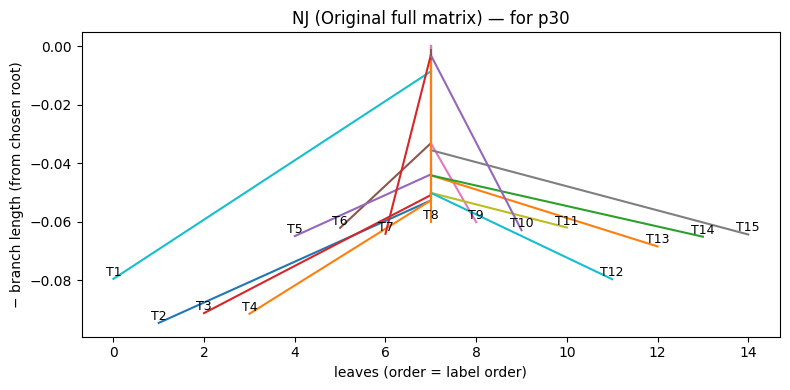

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for MW*...
    MW* NJ tree built


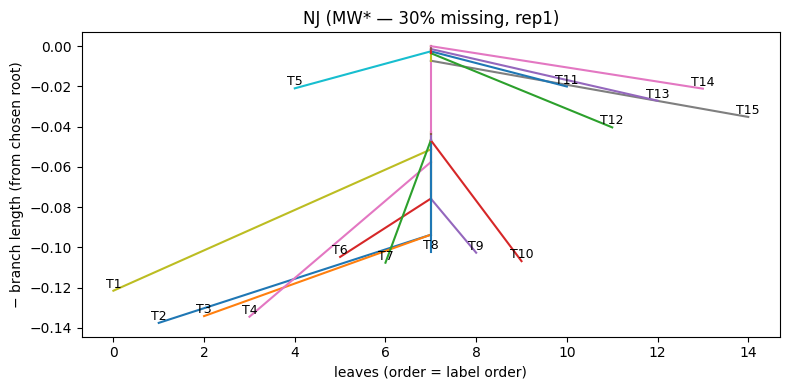

    Saved: tree_MWstar_rep1.png, tree_MWstar_rep1.newick

  Summary p30 rep1:
    RF_norm=0.583333 | pat_RMSE=0.010544 | mat_RMSE=0.010558

----------------------------------------------------------------------
p30 | replicate 2: mwstar_completed_matrices_preserveobs/MWstar_completed_p30_rep2.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p30_rep2.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


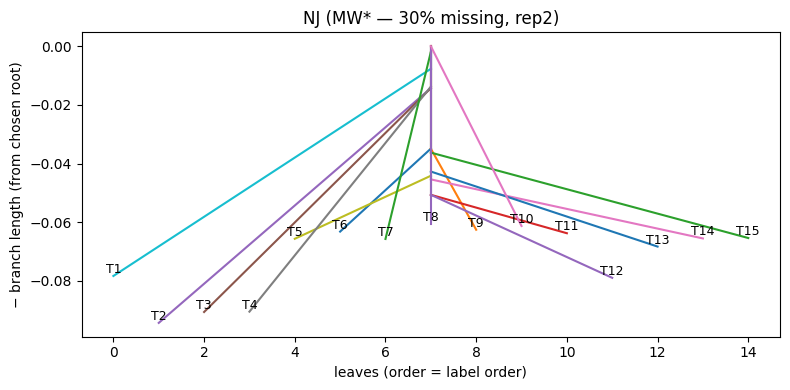

    Saved: tree_MWstar_rep2.png, tree_MWstar_rep2.newick

  Summary p30 rep2:
    RF_norm=0.500000 | pat_RMSE=0.012689 | mat_RMSE=0.012716

----------------------------------------------------------------------
p30 | replicate 3: mwstar_completed_matrices_preserveobs/MWstar_completed_p30_rep3.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p30_rep3.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


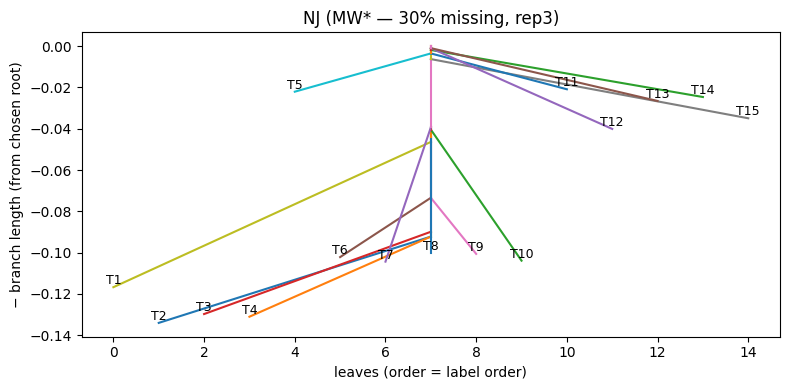

    Saved: tree_MWstar_rep3.png, tree_MWstar_rep3.newick

  Summary p30 rep3:
    RF_norm=0.583333 | pat_RMSE=0.002889 | mat_RMSE=0.002528

----------------------------------------------------------------------
p30 | replicate 4: mwstar_completed_matrices_preserveobs/MWstar_completed_p30_rep4.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p30_rep4.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


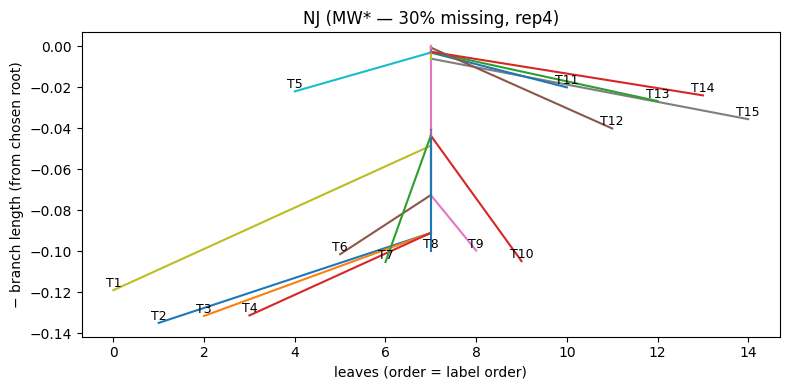

    Saved: tree_MWstar_rep4.png, tree_MWstar_rep4.newick

  Summary p30 rep4:
    RF_norm=0.500000 | pat_RMSE=0.002310 | mat_RMSE=0.002270

----------------------------------------------------------------------
p30 | replicate 5: mwstar_completed_matrices_preserveobs/MWstar_completed_p30_rep5.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p30_rep5.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


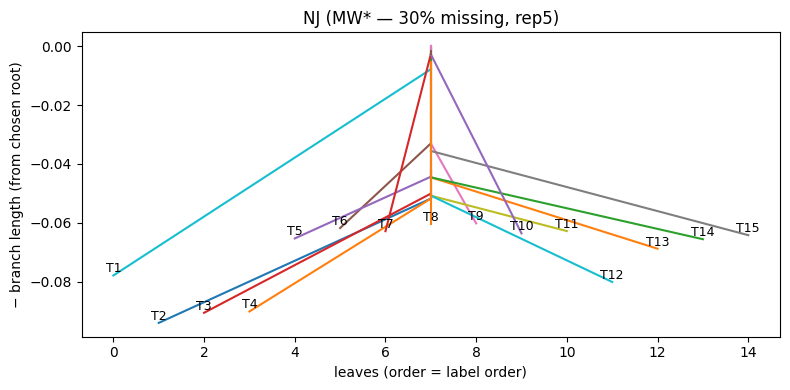

    Saved: tree_MWstar_rep5.png, tree_MWstar_rep5.newick

  Summary p30 rep5:
    RF_norm=0.000000 | pat_RMSE=0.000917 | mat_RMSE=0.001235

Processing MW* NJ trees for 50% missing (rep1..5)

----------------------------------------------------------------------
p50 | replicate 1: mwstar_completed_matrices_preserveobs/MWstar_completed_p50_rep1.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p50_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


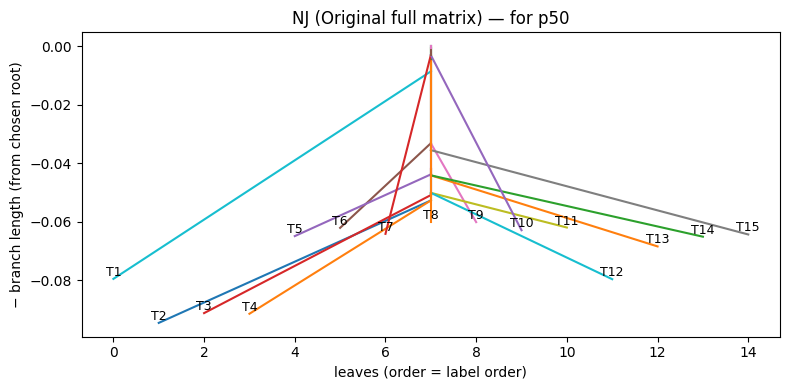

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for MW*...
    MW* NJ tree built


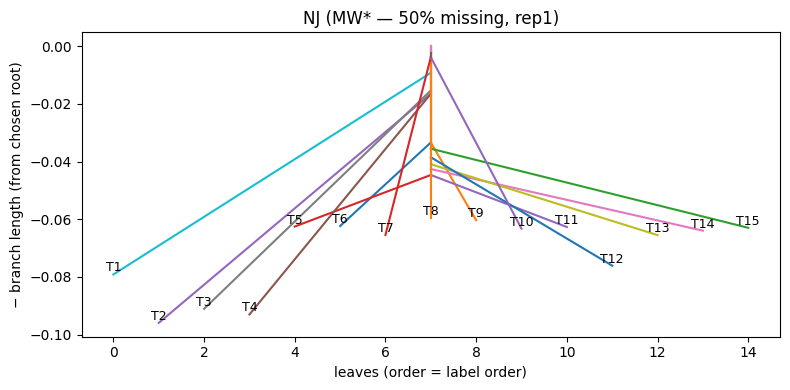

    Saved: tree_MWstar_rep1.png, tree_MWstar_rep1.newick

  Summary p50 rep1:
    RF_norm=0.333333 | pat_RMSE=0.012702 | mat_RMSE=0.012708

----------------------------------------------------------------------
p50 | replicate 2: mwstar_completed_matrices_preserveobs/MWstar_completed_p50_rep2.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p50_rep2.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


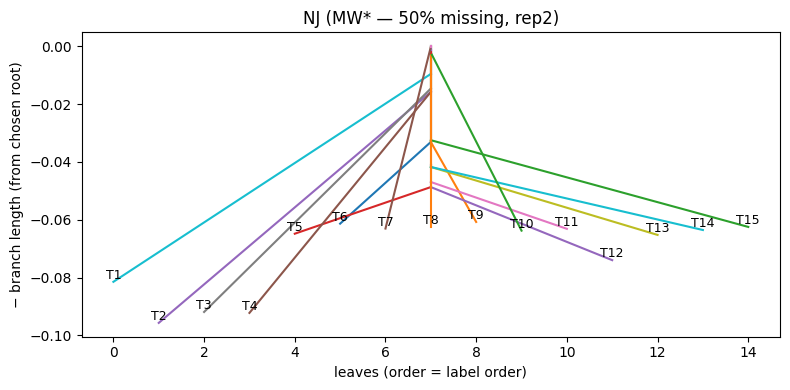

    Saved: tree_MWstar_rep2.png, tree_MWstar_rep2.newick

  Summary p50 rep2:
    RF_norm=0.333333 | pat_RMSE=0.013032 | mat_RMSE=0.013101

----------------------------------------------------------------------
p50 | replicate 3: mwstar_completed_matrices_preserveobs/MWstar_completed_p50_rep3.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p50_rep3.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


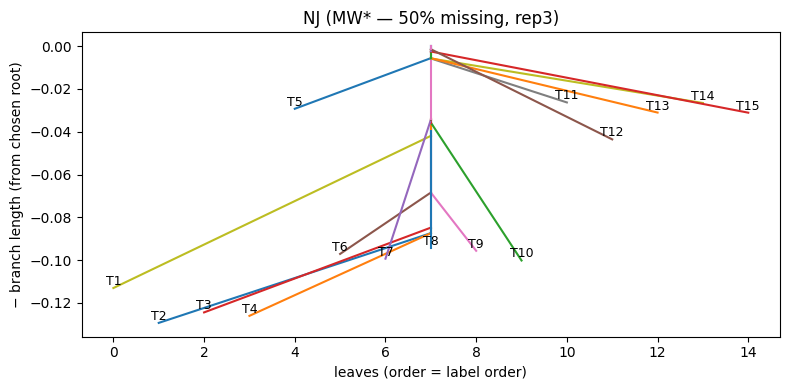

    Saved: tree_MWstar_rep3.png, tree_MWstar_rep3.newick

  Summary p50 rep3:
    RF_norm=0.583333 | pat_RMSE=0.004917 | mat_RMSE=0.004706

----------------------------------------------------------------------
p50 | replicate 4: mwstar_completed_matrices_preserveobs/MWstar_completed_p50_rep4.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p50_rep4.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


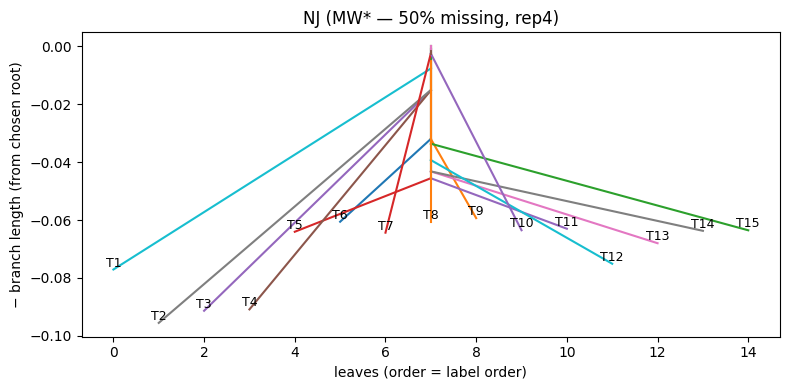

    Saved: tree_MWstar_rep4.png, tree_MWstar_rep4.newick

  Summary p50 rep4:
    RF_norm=0.250000 | pat_RMSE=0.012925 | mat_RMSE=0.012996

----------------------------------------------------------------------
p50 | replicate 5: mwstar_completed_matrices_preserveobs/MWstar_completed_p50_rep5.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p50_rep5.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


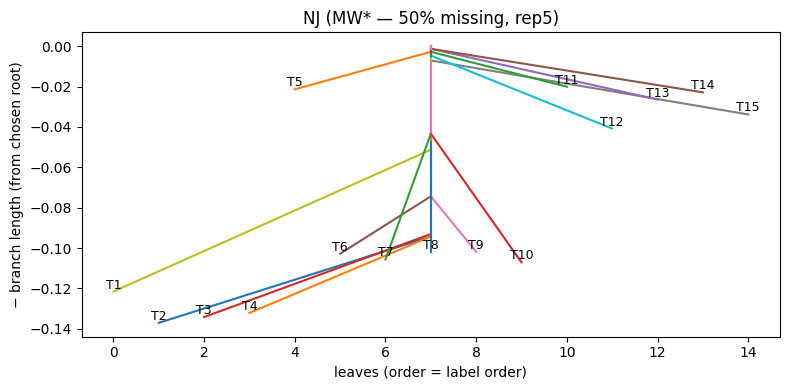

    Saved: tree_MWstar_rep5.png, tree_MWstar_rep5.newick

  Summary p50 rep5:
    RF_norm=0.416667 | pat_RMSE=0.003183 | mat_RMSE=0.003144

Processing MW* NJ trees for 65% missing (rep1..5)

----------------------------------------------------------------------
p65 | replicate 1: mwstar_completed_matrices_preserveobs/MWstar_completed_p65_rep1.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p65_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


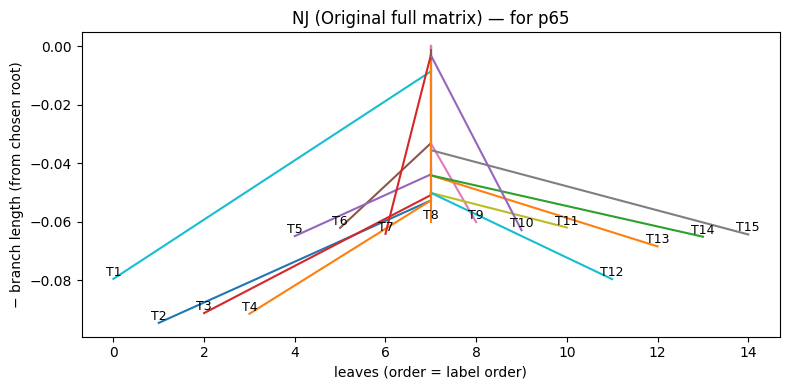

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for MW*...
    MW* NJ tree built


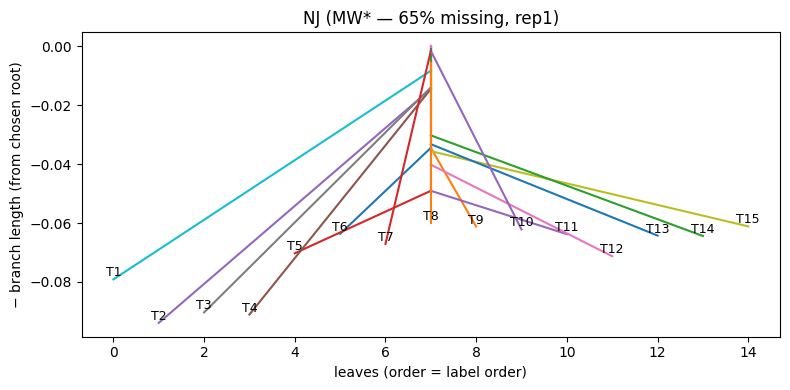

    Saved: tree_MWstar_rep1.png, tree_MWstar_rep1.newick

  Summary p65 rep1:
    RF_norm=0.250000 | pat_RMSE=0.013995 | mat_RMSE=0.014168

----------------------------------------------------------------------
p65 | replicate 2: mwstar_completed_matrices_preserveobs/MWstar_completed_p65_rep2.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p65_rep2.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


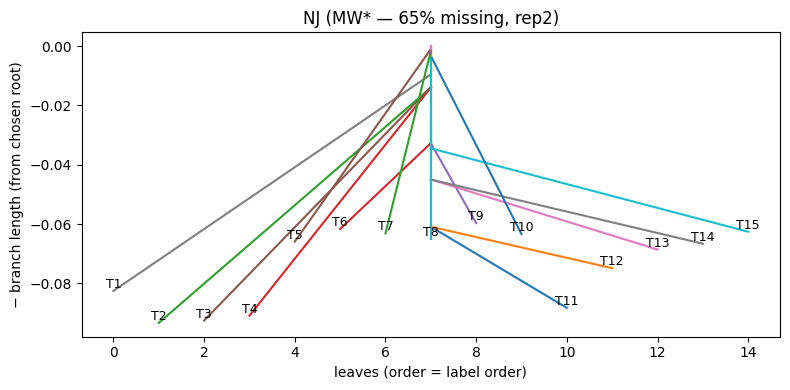

    Saved: tree_MWstar_rep2.png, tree_MWstar_rep2.newick

  Summary p65 rep2:
    RF_norm=0.500000 | pat_RMSE=0.026372 | mat_RMSE=0.026480

----------------------------------------------------------------------
p65 | replicate 3: mwstar_completed_matrices_preserveobs/MWstar_completed_p65_rep3.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p65_rep3.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


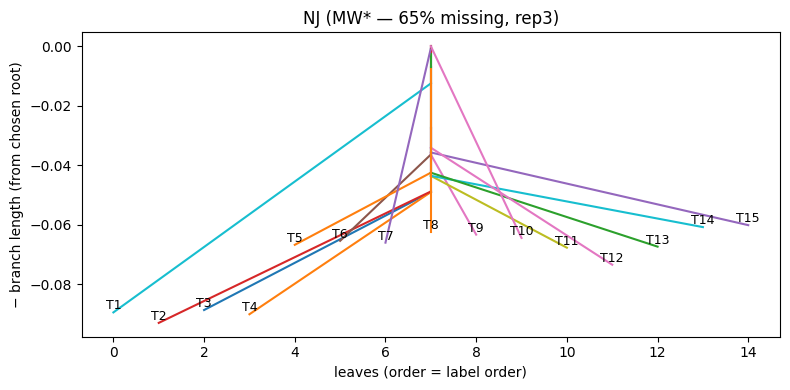

    Saved: tree_MWstar_rep3.png, tree_MWstar_rep3.newick

  Summary p65 rep3:
    RF_norm=0.500000 | pat_RMSE=0.009505 | mat_RMSE=0.009787

----------------------------------------------------------------------
p65 | replicate 4: mwstar_completed_matrices_preserveobs/MWstar_completed_p65_rep4.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p65_rep4.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


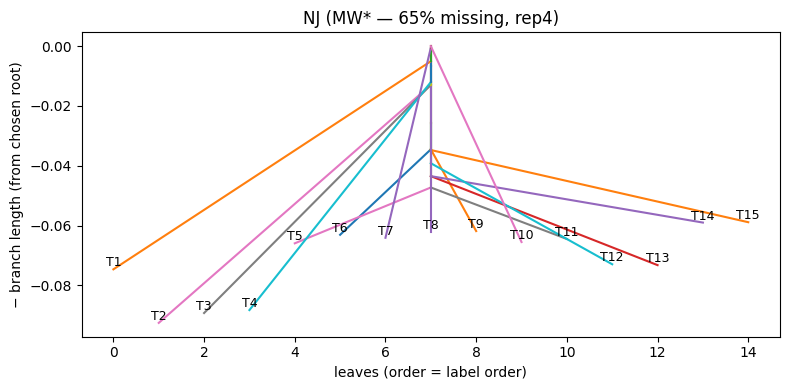

    Saved: tree_MWstar_rep4.png, tree_MWstar_rep4.newick

  Summary p65 rep4:
    RF_norm=0.333333 | pat_RMSE=0.015503 | mat_RMSE=0.015851

----------------------------------------------------------------------
p65 | replicate 5: mwstar_completed_matrices_preserveobs/MWstar_completed_p65_rep5.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p65_rep5.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


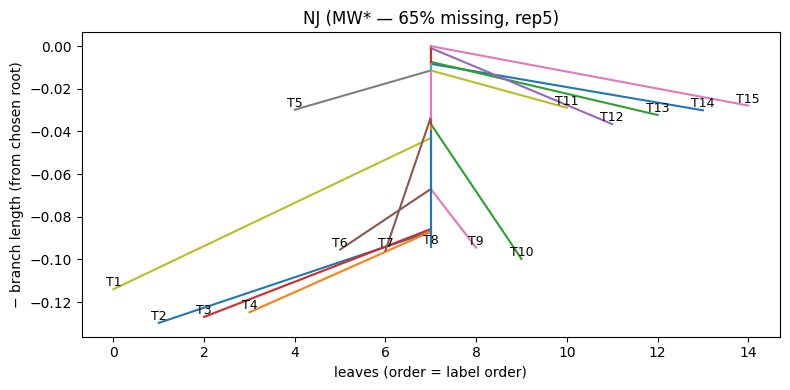

    Saved: tree_MWstar_rep5.png, tree_MWstar_rep5.newick

  Summary p65 rep5:
    RF_norm=0.500000 | pat_RMSE=0.003949 | mat_RMSE=0.003656

Processing MW* NJ trees for 85% missing (rep1..5)

----------------------------------------------------------------------
p85 | replicate 1: mwstar_completed_matrices_preserveobs/MWstar_completed_p85_rep1.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p85_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


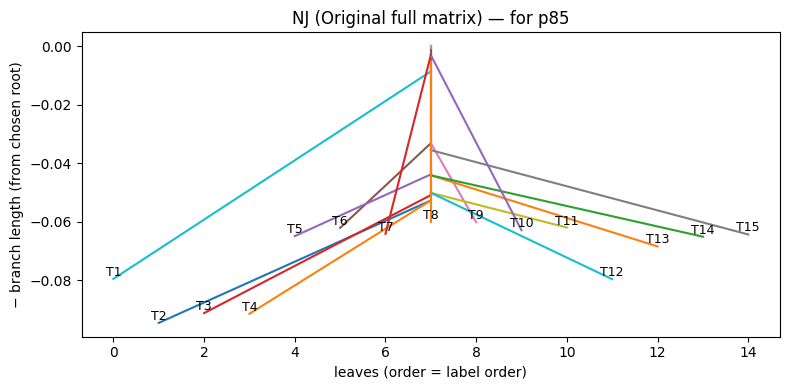

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for MW*...
    MW* NJ tree built


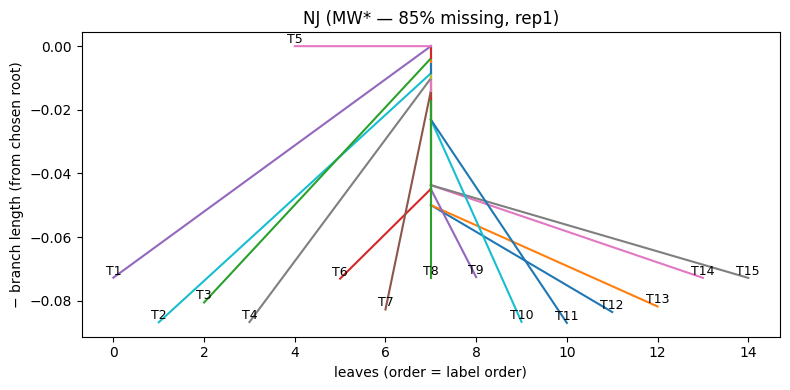

    Saved: tree_MWstar_rep1.png, tree_MWstar_rep1.newick

  Summary p85 rep1:
    RF_norm=0.833333 | pat_RMSE=0.039840 | mat_RMSE=0.039715

----------------------------------------------------------------------
p85 | replicate 2: mwstar_completed_matrices_preserveobs/MWstar_completed_p85_rep2.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p85_rep2.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


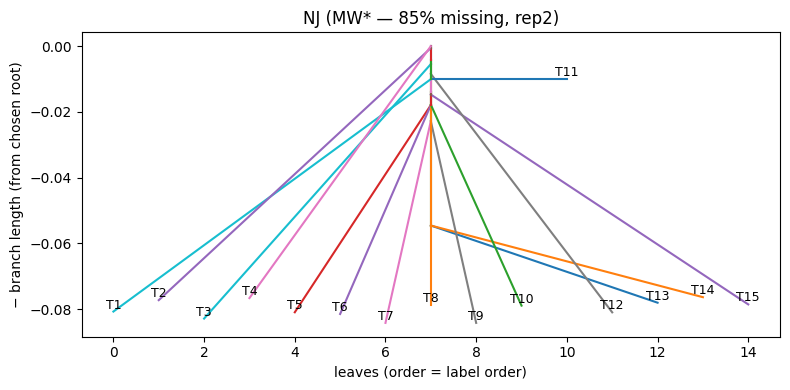

    Saved: tree_MWstar_rep2.png, tree_MWstar_rep2.newick

  Summary p85 rep2:
    RF_norm=0.916667 | pat_RMSE=0.039366 | mat_RMSE=0.039347

----------------------------------------------------------------------
p85 | replicate 3: mwstar_completed_matrices_preserveobs/MWstar_completed_p85_rep3.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p85_rep3.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


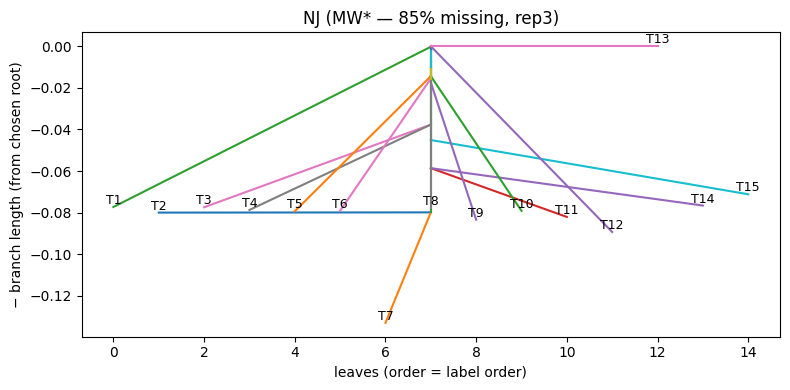

    Saved: tree_MWstar_rep3.png, tree_MWstar_rep3.newick

  Summary p85 rep3:
    RF_norm=1.000000 | pat_RMSE=0.048219 | mat_RMSE=0.048153

----------------------------------------------------------------------
p85 | replicate 4: mwstar_completed_matrices_preserveobs/MWstar_completed_p85_rep4.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p85_rep4.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


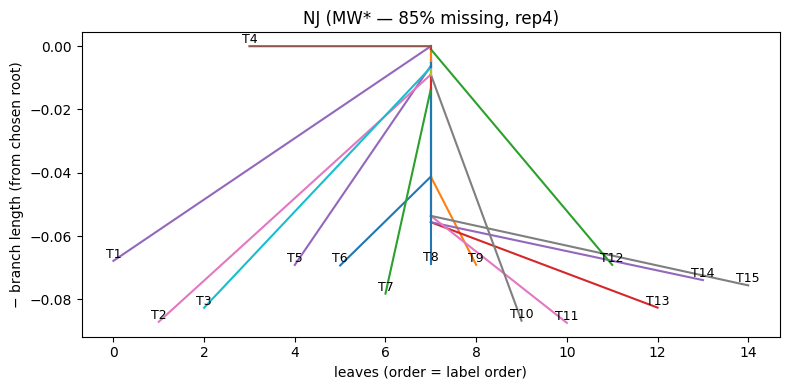

    Saved: tree_MWstar_rep4.png, tree_MWstar_rep4.newick

  Summary p85 rep4:
    RF_norm=0.750000 | pat_RMSE=0.042526 | mat_RMSE=0.042351

----------------------------------------------------------------------
p85 | replicate 5: mwstar_completed_matrices_preserveobs/MWstar_completed_p85_rep5.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p85_rep5.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


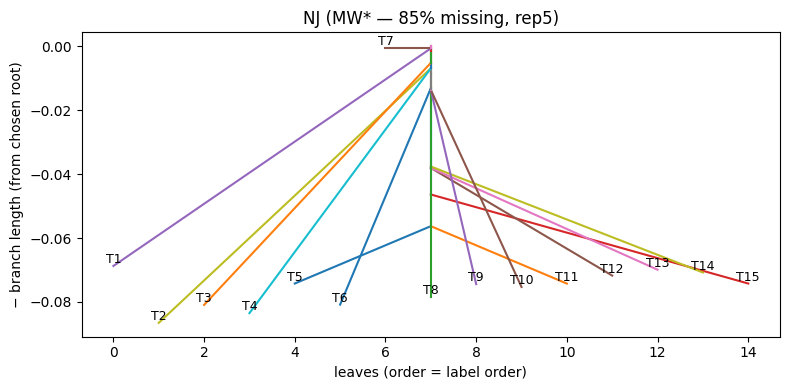

    Saved: tree_MWstar_rep5.png, tree_MWstar_rep5.newick

  Summary p85 rep5:
    RF_norm=0.833333 | pat_RMSE=0.040067 | mat_RMSE=0.039958

Processing MW* NJ trees for 90% missing (rep1..5)

----------------------------------------------------------------------
p90 | replicate 1: mwstar_completed_matrices_preserveobs/MWstar_completed_p90_rep1.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p90_rep1.csv | shape=(15, 15)
  Building NJ tree for original matrix (once for this p)...
    Original NJ tree built


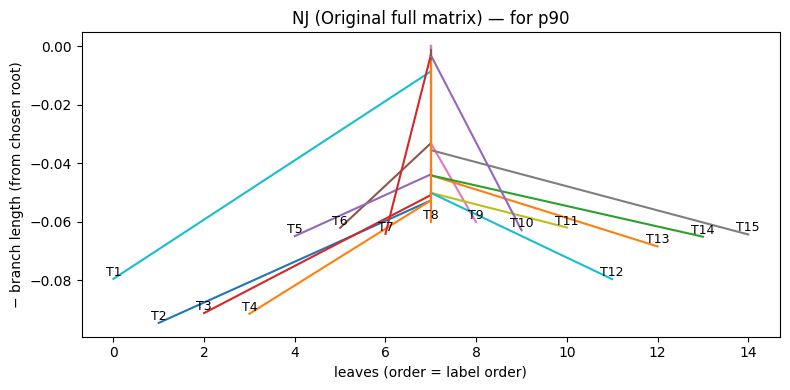

    Saved: tree_Original.png, tree_Original.newick
  Building NJ tree for MW*...
    MW* NJ tree built


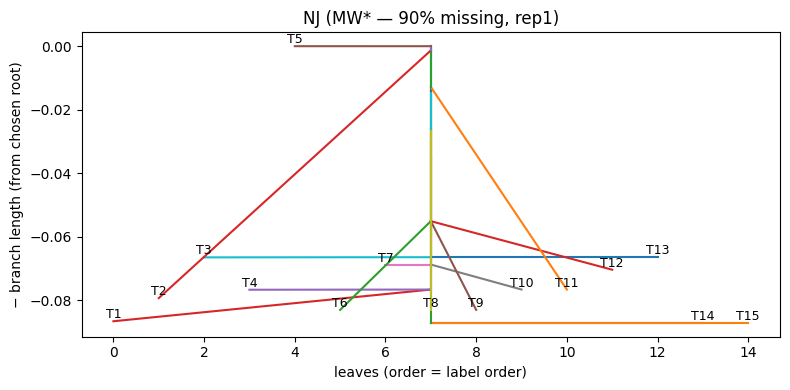

    Saved: tree_MWstar_rep1.png, tree_MWstar_rep1.newick

  Summary p90 rep1:
    RF_norm=0.916667 | pat_RMSE=0.052075 | mat_RMSE=0.051786

----------------------------------------------------------------------
p90 | replicate 2: mwstar_completed_matrices_preserveobs/MWstar_completed_p90_rep2.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p90_rep2.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


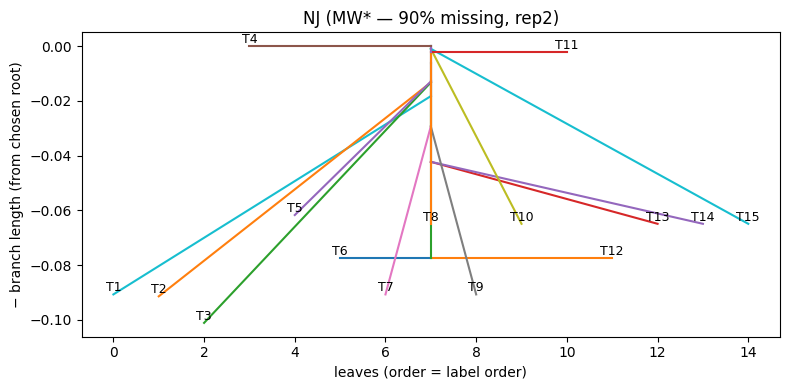

    Saved: tree_MWstar_rep2.png, tree_MWstar_rep2.newick

  Summary p90 rep2:
    RF_norm=0.916667 | pat_RMSE=0.046371 | mat_RMSE=0.046270

----------------------------------------------------------------------
p90 | replicate 3: mwstar_completed_matrices_preserveobs/MWstar_completed_p90_rep3.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p90_rep3.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


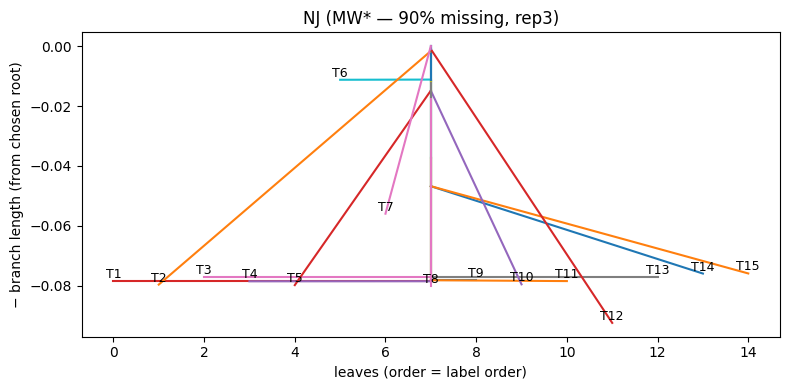

    Saved: tree_MWstar_rep3.png, tree_MWstar_rep3.newick

  Summary p90 rep3:
    RF_norm=1.000000 | pat_RMSE=0.053412 | mat_RMSE=0.053358

----------------------------------------------------------------------
p90 | replicate 4: mwstar_completed_matrices_preserveobs/MWstar_completed_p90_rep4.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p90_rep4.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


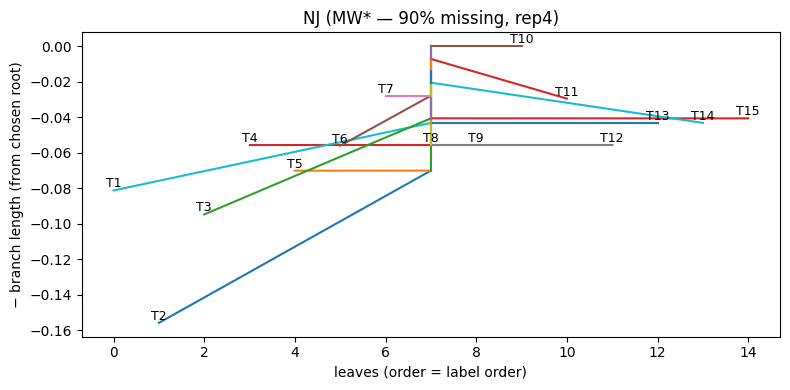

    Saved: tree_MWstar_rep4.png, tree_MWstar_rep4.newick

  Summary p90 rep4:
    RF_norm=1.000000 | pat_RMSE=0.057672 | mat_RMSE=0.057526

----------------------------------------------------------------------
p90 | replicate 5: mwstar_completed_matrices_preserveobs/MWstar_completed_p90_rep5.csv
----------------------------------------------------------------------
  Loaded MW* matrix: MWstar_completed_p90_rep5.csv | shape=(15, 15)
  Building NJ tree for MW*...
    MW* NJ tree built


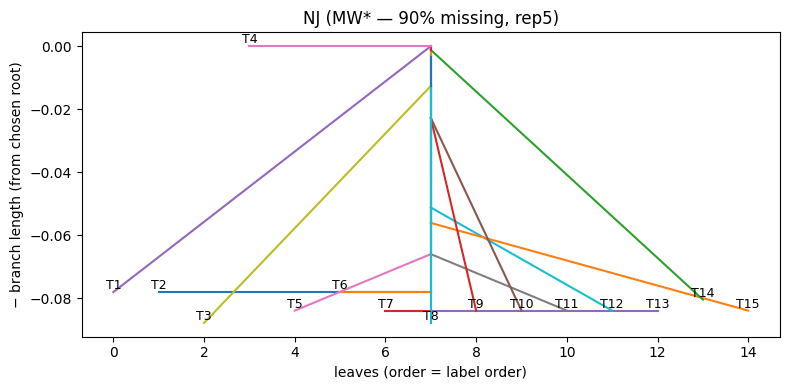

    Saved: tree_MWstar_rep5.png, tree_MWstar_rep5.newick

  Summary p90 rep5:
    RF_norm=1.000000 | pat_RMSE=0.051565 | mat_RMSE=0.051389

Detailed Tree Benchmark Results (ALL processed)
 pct_missing  replicate                          file  RF  RF_norm  n_splits  pat_MAE  pat_RMSE  pat_Pearson  pat_Spearman
          30          1 MWstar_completed_p30_rep1.csv  14 0.583333        12 0.002658  0.010544     0.955848      0.950373
          30          2 MWstar_completed_p30_rep2.csv  12 0.500000        12 0.003551  0.012689     0.937310      0.914047
          30          3 MWstar_completed_p30_rep3.csv  14 0.583333        12 0.001768  0.002889     0.996909      0.982231
          30          4 MWstar_completed_p30_rep4.csv  12 0.500000        12 0.001200  0.002310     0.998185      0.993749
          30          5 MWstar_completed_p30_rep5.csv   0 0.000000        12 0.000705  0.000917     0.999776      0.997025
          50          1 MWstar_completed_p50_rep1.csv   8 0.333333        

In [7]:
# Cell — PICTURES OF TREES (30/50/65/85% missing × 5 replicates) for MW*
# NJ version + detailed benchmarks + mean ± SD by missingness + all-levels CSV
#
# Expected inputs (default):
#   mwstar_completed_matrices/MWstar_completed_p{30,50,65,85}_rep{1..5}.csv
#
# Output:
#   trees_mwstar_nj_all15/
#     p30/ tree_Original.png, tree_MWstar_rep1.png ... tree_MWstar_rep5.png, *.newick
#     p50/ ...
#     p65/ ...
#     p85/ ...
#     benchmark_tree_all15.csv
#     benchmark_matrix_all15.csv
#     benchmark_tree_by_missingness.csv
#     benchmark_matrix_by_missingness.csv
#     stats_tree_by_missingness.csv
#     stats_matrix_by_missingness.csv
#
# Notes:
# - "Matrix metrics" compare the COMPLETED MW* distance matrix vs the ORIGINAL full matrix (upper-triangle vectors).
# - "Tree metrics" compare NJ trees built from those matrices (splits via unrooted splits on the undirected tree).

import os
import warnings
from dataclasses import dataclass
from typing import Dict, List, Set, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


# ============================================================
# I/O HELPERS
# ============================================================
def load_matrix_with_candidates(cands: List[str]) -> Tuple[np.ndarray, str]:
    for p in cands:
        if os.path.exists(p):
            M = np.loadtxt(p)
            # heuristic: if distances are in ~1000s, rescale to ~units
            if np.nanmax(M) > 500:
                M = M / 1000.0
            return M, p
    raise FileNotFoundError(f"File not found. Tried: {cands}")


def load_completed_csv(path_csv: str) -> Tuple[np.ndarray, List[str]]:
    if not os.path.exists(path_csv):
        raise FileNotFoundError(path_csv)
    df = pd.read_csv(path_csv, index_col=0)
    labels_cols = list(df.columns)
    labels_idx = list(df.index)
    # Prefer columns as labels; sanity-check consistency if possible
    if len(labels_cols) == len(labels_idx) and all(str(a) == str(b) for a, b in zip(labels_idx, labels_cols)):
        labels = labels_cols
    else:
        labels = labels_cols
    return df.values.astype(float), labels


# ============================================================
# SANITIZATION
# ============================================================
def _finite_fill(v, fallback: float = 1.0) -> float:
    v = np.asarray(v, dtype=float)
    vv = v[np.isfinite(v)]
    if vv.size > 0:
        return float(np.nanmedian(vv))
    return float(fallback)


def sanitize_distance_matrix(D: np.ndarray, name: str = "D", force_nonneg: bool = True) -> np.ndarray:
    M = np.array(D, dtype=float)
    if M.ndim != 2 or M.shape[0] != M.shape[1]:
        raise ValueError(f"{name} must be a square matrix. Got shape {M.shape}.")

    n = M.shape[0]

    # remove negative off-diagonal (treat as missing)
    neg = (M < 0)
    np.fill_diagonal(neg, False)
    M[neg] = np.nan

    off = ~np.eye(n, dtype=bool)
    med = _finite_fill(M[off], fallback=1.0)

    # fill NaN/inf with median
    M = np.nan_to_num(M, nan=med, posinf=med, neginf=med)

    # winsorize extreme upper tail on off-diagonal
    try:
        q = np.quantile(M[off], 0.995)
    except Exception:
        q = np.nan
    if np.isfinite(q) and q > 0:
        M[off] = np.minimum(M[off], q)

    # symmetrize + nonneg + zero diagonal
    M = 0.5 * (M + M.T)
    if force_nonneg:
        M = np.maximum(M, 0.0)
    np.fill_diagonal(M, 0.0)

    if not np.isfinite(M).all():
        raise ValueError(f"{name} has non-finite entries after sanitize.")
    return M


# ============================================================
# NJ TREE OBJECT
# ============================================================
@dataclass
class NJTree:
    newick: str
    patristic: np.ndarray            # n x n leaf-to-leaf path lengths
    splits: Set[frozenset]           # unrooted splits (bipartitions) as leaf-label sets
    adj: Dict[int, Dict[int, float]] # weighted undirected adjacency
    root: int                        # chosen root node id for Newick/drawing


# ============================================================
# NJ (Neighbor-Joining) + splits/patristic
# ============================================================
def neighbor_joining_nonneg(D_full: np.ndarray, labels: List[str], eps: float = 1e-12) -> NJTree:
    D = sanitize_distance_matrix(D_full, "NJ_input", force_nonneg=True)
    n = len(labels)
    if D.shape != (n, n):
        raise ValueError(f"Distance matrix shape {D.shape} does not match number of labels n={n}.")

    # adjacency for final tree
    adj: Dict[int, Dict[int, float]] = {}

    def add_edge(u: int, v: int, w: float):
        w = float(w)
        if not np.isfinite(w):
            w = 1e-9
        w = max(w, 1e-9)  # keep strictly positive for drawing/path lengths
        adj.setdefault(u, {})
        adj.setdefault(v, {})
        adj[u][v] = w
        adj[v][u] = w

    # Special small-n cases
    if n == 1:
        root = 0
        newick = f"{labels[0]};"
        P = np.zeros((1, 1), dtype=float)
        splits = set()
        return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)

    if n == 2:
        # Represent as rooted 2-leaf tree
        root = 2
        d01 = float(D[0, 1])
        add_edge(root, 0, 0.5 * d01)
        add_edge(root, 1, 0.5 * d01)
        newick = f"({labels[0]}:{0.5*d01:.6f},{labels[1]}:{0.5*d01:.6f});"
        P = np.array([[0.0, d01], [d01, 0.0]], dtype=float)
        splits = set()
        return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)

    # Active nodes and current distance dict (between active nodes only)
    next_id = n
    active = list(range(n))

    dist: Dict[Tuple[int, int], float] = {}
    for i in range(n):
        for j in range(i + 1, n):
            dist[(i, j)] = float(D[i, j])

    def get_dist(a: int, b: int) -> float:
        if a == b:
            return 0.0
        key = (a, b) if a < b else (b, a)
        return float(dist.get(key, 0.0))

    # Main NJ loop
    last_created = None
    while len(active) > 2:
        m = len(active)

        # r_i = sum_k d(i,k)
        r = {i: 0.0 for i in active}
        for ii in range(m):
            i = active[ii]
            s = 0.0
            for jj in range(m):
                if ii == jj:
                    continue
                j = active[jj]
                s += get_dist(i, j)
            r[i] = float(s)

        # find (i,j) minimizing Q_ij = (m-2)*d_ij - r_i - r_j
        best_pair = None
        best_q = np.inf
        for a_idx in range(m):
            i = active[a_idx]
            for b_idx in range(a_idx + 1, m):
                j = active[b_idx]
                dij = get_dist(i, j)
                q = (m - 2) * dij - r[i] - r[j]
                if q < best_q:
                    best_q = q
                    best_pair = (i, j)

        i, j = best_pair
        dij = get_dist(i, j)

        # limb lengths
        denom = max(m - 2, 1)
        delta = (r[i] - r[j]) / float(denom)
        li = 0.5 * dij + 0.5 * delta
        lj = dij - li

        # clamp (numerical stability)
        if not np.isfinite(li):
            li = 0.5 * dij
        if not np.isfinite(lj):
            lj = 0.5 * dij
        li = max(li, 1e-9)
        lj = max(lj, 1e-9)

        u = next_id
        next_id += 1
        last_created = u

        add_edge(u, i, li)
        add_edge(u, j, lj)

        # compute distances from new node u to every other k:
        # d(u,k) = 0.5*(d(i,k) + d(j,k) - d(i,j))
        new_dist_entries = {}
        for k in active:
            if k in (i, j):
                continue
            dik = get_dist(i, k)
            djk = get_dist(j, k)
            duk = 0.5 * (dik + djk - dij)
            if not np.isfinite(duk):
                duk = 0.5 * (dik + djk)
            duk = max(duk, 0.0)  # NJ can yield small negative from non-additivity
            key = (k, u) if k < u else (u, k)
            new_dist_entries[key] = float(duk)

        # remove old distances involving i or j
        to_del = []
        for (a, b) in list(dist.keys()):
            if a in (i, j) or b in (i, j):
                to_del.append((a, b))
        for kkey in to_del:
            dist.pop(kkey, None)

        # add new distances
        dist.update(new_dist_entries)

        # update active set
        active = [k for k in active if k not in (i, j)]
        active.append(u)

    # final connection between the last two nodes
    a, b = active[0], active[1]
    dab = get_dist(a, b)
    if not np.isfinite(dab):
        dab = 0.0
    dab = max(dab, 1e-9)
    add_edge(a, b, dab)

    # choose a root for Newick/drawing: prefer an internal node if possible
    root_candidates = [x for x in adj.keys() if x >= n]
    root = max(root_candidates) if root_candidates else a

    # Newick serialization (rooted at 'root')
    def to_newick(x: int, parent: int = -1) -> str:
        if x < n:
            return labels[x]
        parts = []
        for v, w in adj.get(x, {}).items():
            if v == parent:
                continue
            parts.append(f"{to_newick(v, x)}:{w:.6f}")
        return "(" + ",".join(parts) + ")"

    newick = to_newick(root) + ";"

    # patristic distances between leaves
    def path_len(src: int, dst: int) -> float:
        stack = [(src, -1, 0.0)]
        visited = set()
        while stack:
            x, p, acc = stack.pop()
            if x == dst:
                return acc
            visited.add(x)
            for y, w in adj.get(x, {}).items():
                if y == p or y in visited:
                    continue
                stack.append((y, x, acc + w))
        return np.nan

    P = np.zeros((n, n), dtype=float)
    for ii in range(n):
        for jj in range(ii + 1, n):
            d = path_len(ii, jj)
            P[ii, jj] = P[jj, ii] = d

    # unrooted splits from adjacency
    def compute_splits() -> Set[frozenset]:
        splits = set()
        seen_edges = set()
        for u in adj:
            for v in adj[u]:
                if (v, u) in seen_edges:
                    continue
                seen_edges.add((u, v))

                # collect leaves on u-side when blocking traversal across edge (u,v)
                stack = [u]
                blocked = v
                visited = set([blocked])
                leafset = set()

                while stack:
                    x = stack.pop()
                    if x in visited:
                        continue
                    visited.add(x)
                    if x < n:
                        leafset.add(labels[x])
                    for y in adj.get(x, {}):
                        if y not in visited:
                            stack.append(y)

                if 1 < len(leafset) < n - 1:
                    splits.add(frozenset(sorted(leafset)))
        return splits

    splits = compute_splits()
    return NJTree(newick=newick, patristic=P, splits=splits, adj=adj, root=root)


# ============================================================
# TREE DRAWING (simple rooted phylogram for NJ)
# ============================================================
def draw_nj_tree(t: NJTree, labels: List[str], title: str, out_path: str = None, dpi: int = 160, show: bool = True):
    n = len(labels)
    x_pos = {i: i for i in range(n)}
    y_pos: Dict[int, float] = {}

    # y = accumulated branch length from root (downwards)
    def dfs(u: int, p: int = -1, y: float = 0.0):
        y_pos[u] = -y
        for v, w in t.adj.get(u, {}).items():
            if v == p:
                continue
            dfs(v, u, y + float(w))

    dfs(t.root, -1, 0.0)

    def leaf_span(node: int) -> float:
        if node < n:
            return float(x_pos[node])
        seen = set()
        stack = [node]
        leaves = []
        while stack:
            x = stack.pop()
            if x in seen:
                continue
            seen.add(x)
            if x < n:
                leaves.append(x_pos[x])
            else:
                for y in t.adj.get(x, {}):
                    if y not in seen:
                        stack.append(y)
        return float(np.mean(leaves)) if leaves else 0.0

    plt.figure(figsize=(8, 4))
    drawn = set()
    for u in t.adj:
        for v, w in t.adj[u].items():
            if (v, u) in drawn:
                continue
            drawn.add((u, v))
            plt.plot([leaf_span(u), leaf_span(v)],
                     [y_pos.get(u, 0.0), y_pos.get(v, 0.0)],
                     linewidth=1.5)

    for i in range(n):
        plt.text(leaf_span(i), y_pos.get(i, 0.0), labels[i],
                 ha="center", va="bottom", fontsize=9)

    plt.title(title)
    plt.xlabel("leaves (order = label order)")
    plt.ylabel("− branch length (from chosen root)")
    plt.tight_layout()

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=dpi)

    if show:
        plt.show()
    else:
        plt.close()


# ============================================================
# BENCHMARKS (same as your UPGMA cell)
# ============================================================
def rf_distance(t1: NJTree, t2: NJTree) -> int:
    return len(t1.splits - t2.splits) + len(t2.splits - t1.splits)


def rf_normalized(t1: NJTree, t2: NJTree, n_leaves: int) -> float:
    if n_leaves < 4:
        return 0.0
    rf = rf_distance(t1, t2)
    rf_max = 2 * (n_leaves - 3)
    return float(rf) / float(rf_max) if rf_max > 0 else 0.0


def _upper_vec(M: np.ndarray) -> np.ndarray:
    M = np.asarray(M, dtype=float)
    iu = np.triu_indices(M.shape[0], k=1)
    v = M[iu]
    v = v[np.isfinite(v)]
    return v


def _pearson(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    if a.size == 0 or b.size == 0:
        return float("nan")
    if np.std(a) == 0 or np.std(b) == 0:
        return float("nan")
    return float(np.corrcoef(a, b)[0, 1])


def _spearman(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    if a.size == 0 or b.size == 0:
        return float("nan")
    ra = pd.Series(a).rank(method="average").to_numpy()
    rb = pd.Series(b).rank(method="average").to_numpy()
    return _pearson(ra, rb)


def patristic_metrics(t: NJTree, tref: NJTree) -> Dict[str, float]:
    v = _upper_vec(t.patristic)
    vr = _upper_vec(tref.patristic)
    m = min(v.size, vr.size)
    if m == 0:
        return {"pat_MAE": np.nan, "pat_RMSE": np.nan, "pat_Pearson": np.nan, "pat_Spearman": np.nan}
    v = v[:m]
    vr = vr[:m]
    diff = v - vr
    return {
        "pat_MAE": float(np.mean(np.abs(diff))),
        "pat_RMSE": float(np.sqrt(np.mean(diff * diff))),
        "pat_Pearson": _pearson(v, vr),
        "pat_Spearman": _spearman(v, vr),
    }


def matrix_metrics(D: np.ndarray, Dref: np.ndarray) -> Dict[str, float]:
    v = _upper_vec(D)
    vr = _upper_vec(Dref)
    m = min(v.size, vr.size)
    if m == 0:
        return {"MAE": np.nan, "RMSE": np.nan, "Pearson": np.nan, "Spearman": np.nan}
    v = v[:m]
    vr = vr[:m]
    diff = v - vr
    return {
        "MAE": float(np.mean(np.abs(diff))),
        "RMSE": float(np.sqrt(np.mean(diff * diff))),
        "Pearson": _pearson(v, vr),
        "Spearman": _spearman(v, vr),
    }


# ============================================================
# mean ± SD helper (by group)
# ============================================================
def mean_std_table(df: pd.DataFrame, group_col: str, metrics: List[str], digits: Dict[str, int]) -> pd.DataFrame:
    rows = []
    for g, sub in df.groupby(group_col):
        row = {group_col: g}
        for m in metrics:
            if m not in sub.columns:
                row[m] = "nan ± nan"
                continue
            s = pd.to_numeric(sub[m], errors="coerce").dropna()
            if len(s) == 0:
                row[m] = "nan ± nan"
                continue
            mu = float(s.mean())
            sd = float(s.std(ddof=1)) if len(s) > 1 else 0.0
            d = int(digits.get(m, 6))
            row[m] = f"{mu:.{d}f} ± {sd:.{d}f}"
        rows.append(row)
    out = pd.DataFrame(rows).sort_values(group_col).reset_index(drop=True)
    return out


# ============================================================
# MAIN
# ============================================================
missingness_levels = [30, 50, 65, 85, 90]
replicates = [1, 2, 3, 4, 5]

completed_root = "mwstar_completed_matrices_preserveobs"
out_root = "trees_mwstar_nj_all15"   # <- NJ output folder
os.makedirs(out_root, exist_ok=True)

SHOW_PLOTS = True  # set False if you do not want 16 figures displayed in the notebook

print("Loading original matrix...")
D0, D0_path = load_matrix_with_candidates([
    "Result_NW_15x15.txt",
    "./Result_NW_15x15.txt",
    "/mnt/data/Result_NW_15x15.txt",
    "Result_NW_20x20.txt",
    "./Result_NW_20x20.txt",
    "/mnt/data/Result_NW_20x20.txt",
])
D0 = sanitize_distance_matrix(D0, "D_orig", force_nonneg=True)
print(f"  Original matrix loaded: {D0_path}")
print(f"  Original matrix shape: {D0.shape}")

all_tree_results = []
all_matrix_results = []

labels_ref: Optional[List[str]] = None

for p in missingness_levels:
    print(f"\n{'='*80}")
    print(f"Processing MW* NJ trees for {p}% missing (rep1..5)")
    print(f"{'='*80}")

    out_dir = os.path.join(out_root, f"p{p}")
    os.makedirs(out_dir, exist_ok=True)

    tree_orig: Optional[NJTree] = None
    D0_adj_global: Optional[np.ndarray] = None

    mw_files = [os.path.join(completed_root, f"MWstar_completed_p{p}_rep{r}.csv") for r in replicates]

    for rep_num, file in zip(replicates, mw_files):
        print(f"\n{'-'*70}")
        print(f"p{p} | replicate {rep_num}: {file}")
        print(f"{'-'*70}")

        if not os.path.exists(file):
            alt_candidates = [
                os.path.join(".", f"MWstar_completed_p{p}_rep{rep_num}.csv"),
                os.path.join(".", "mwstar_completed", f"MWstar_completed_p{p}_rep{rep_num}.csv"),
                os.path.join(out_root, f"MWstar_completed_p{p}_rep{rep_num}.csv"),
            ]
            found_alt = None
            for alt in alt_candidates:
                if os.path.exists(alt):
                    found_alt = alt
                    break
            if found_alt:
                print(f"  NOTE: using alternative path: {found_alt}")
                file = found_alt
            else:
                print(f"  WARNING: file not found. Skipping rep{rep_num}.")
                continue

        # Load MW* completed matrix
        D_mw, labels = load_completed_csv(file)
        print(f"  Loaded MW* matrix: {os.path.basename(file)} | shape={D_mw.shape}")

        if labels_ref is None:
            labels_ref = labels
        else:
            if len(labels) != len(labels_ref):
                print(f"  ERROR: label count mismatch (global). Expected {len(labels_ref)}, got {len(labels)}. Skipping rep.")
                continue

        # Match/crop original to this replicate size if needed
        if D0.shape != D_mw.shape:
            if D0.shape[0] >= D_mw.shape[0]:
                print(f"  Note: cropping original {D0.shape} -> {D_mw.shape} to match MW*.")
                D0_adj = sanitize_distance_matrix(
                    D0[:D_mw.shape[0], :D_mw.shape[1]],
                    "D_orig_cropped",
                    force_nonneg=True
                )
            else:
                print(f"  ERROR: original smaller than MW* ({D0.shape} vs {D_mw.shape}). Skipping rep.")
                continue
        else:
            D0_adj = D0

        if D0_adj_global is None:
            D0_adj_global = D0_adj

        # Sanitize MW*
        D_mw = sanitize_distance_matrix(D_mw, f"D_MWstar_p{p}_rep{rep_num}", force_nonneg=True)

        # Build original NJ tree once per p
        if tree_orig is None:
            print("  Building NJ tree for original matrix (once for this p)...")
            tree_orig = neighbor_joining_nonneg(D0_adj_global, labels)
            print("    Original NJ tree built")

            draw_nj_tree(tree_orig, labels, f"NJ (Original full matrix) — for p{p}",
                         os.path.join(out_dir, "tree_Original.png"), show=SHOW_PLOTS)
            with open(os.path.join(out_dir, "tree_Original.newick"), "w") as f:
                f.write(tree_orig.newick + "\n")
            print("    Saved: tree_Original.png, tree_Original.newick")

        # Build MW* NJ tree
        print("  Building NJ tree for MW*...")
        tree_mw = neighbor_joining_nonneg(D_mw, labels)
        print("    MW* NJ tree built")

        # Draw/save MW* tree + newick
        draw_nj_tree(tree_mw, labels, f"NJ (MW* — {p}% missing, rep{rep_num})",
                     os.path.join(out_dir, f"tree_MWstar_rep{rep_num}.png"), show=SHOW_PLOTS)
        with open(os.path.join(out_dir, f"tree_MWstar_rep{rep_num}.newick"), "w") as f:
            f.write(tree_mw.newick + "\n")
        print(f"    Saved: tree_MWstar_rep{rep_num}.png, tree_MWstar_rep{rep_num}.newick")

        # Benchmarks
        tmet = {
            "pct_missing": p,
            "replicate": rep_num,
            "file": os.path.basename(file),
            "RF": int(rf_distance(tree_mw, tree_orig)),
            "RF_norm": rf_normalized(tree_mw, tree_orig, len(labels)),
            "n_splits": int(len(tree_mw.splits)),
        }
        tmet.update(patristic_metrics(tree_mw, tree_orig))

        mmet = matrix_metrics(D_mw, D0_adj_global)
        mmet = {f"mat_{k}": v for k, v in mmet.items()}
        mmet["pct_missing"] = p
        mmet["replicate"] = rep_num
        mmet["file"] = os.path.basename(file)

        all_tree_results.append(tmet)
        all_matrix_results.append(mmet)

        print(f"\n  Summary p{p} rep{rep_num}:")
        print(f"    RF_norm={tmet['RF_norm']:.6f} | pat_RMSE={tmet['pat_RMSE']:.6f} | mat_RMSE={mmet['mat_RMSE']:.6f}")


# ============================================================
# SAVE + PRINT GLOBAL TABLES + mean ± SD BY MISSINGNESS
# ============================================================
if len(all_tree_results) == 0:
    print("\nERROR: No replicates processed.")
else:
    df_tree = pd.DataFrame(all_tree_results)
    df_matrix = pd.DataFrame(all_matrix_results)

    tree_cols = ["pct_missing", "replicate", "file", "RF", "RF_norm", "n_splits",
                 "pat_MAE", "pat_RMSE", "pat_Pearson", "pat_Spearman"]
    matrix_cols = ["pct_missing", "replicate", "file", "mat_MAE", "mat_RMSE", "mat_Pearson", "mat_Spearman"]

    df_tree = df_tree[[c for c in tree_cols if c in df_tree.columns]]
    df_matrix = df_matrix[[c for c in matrix_cols if c in df_matrix.columns]]

    tree_all_path = os.path.join(out_root, "benchmark_tree_all15.csv")
    mat_all_path = os.path.join(out_root, "benchmark_matrix_all15.csv")
    df_tree.to_csv(tree_all_path, index=False)
    df_matrix.to_csv(mat_all_path, index=False)

    tree_metrics_list = ["RF", "RF_norm", "n_splits", "pat_MAE", "pat_RMSE", "pat_Pearson", "pat_Spearman"]
    mat_metrics_list = ["mat_MAE", "mat_RMSE", "mat_Pearson", "mat_Spearman"]

    digits_tree = {"RF": 4, "RF_norm": 6, "n_splits": 4, "pat_MAE": 6, "pat_RMSE": 6, "pat_Pearson": 6, "pat_Spearman": 6}
    digits_mat  = {"mat_MAE": 6, "mat_RMSE": 6, "mat_Pearson": 6, "mat_Spearman": 6}

    df_tree_stats = mean_std_table(df_tree, "pct_missing", tree_metrics_list, digits_tree)
    df_mat_stats  = mean_std_table(df_matrix, "pct_missing", mat_metrics_list, digits_mat)

    tree_by_path = os.path.join(out_root, "stats_tree_by_missingness.csv")
    mat_by_path  = os.path.join(out_root, "stats_matrix_by_missingness.csv")
    df_tree_stats.to_csv(tree_by_path, index=False)
    df_mat_stats.to_csv(mat_by_path, index=False)

    tree_by_miss = df_tree.sort_values(["pct_missing", "replicate"]).reset_index(drop=True)
    mat_by_miss  = df_matrix.sort_values(["pct_missing", "replicate"]).reset_index(drop=True)
    tree_by_miss_path = os.path.join(out_root, "benchmark_tree_by_missingness.csv")
    mat_by_miss_path  = os.path.join(out_root, "benchmark_matrix_by_missingness.csv")
    tree_by_miss.to_csv(tree_by_miss_path, index=False)
    mat_by_miss.to_csv(mat_by_miss_path, index=False)

    print(f"\n{'='*72}")
    print("Detailed Tree Benchmark Results (ALL processed)")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(tree_by_miss.to_string(index=False))

    print(f"\n{'='*72}")
    print("Detailed Matrix Benchmark Results (ALL processed)")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(mat_by_miss.to_string(index=False))

    print(f"\n{'='*72}")
    print("Tree metrics: mean ± SD by missingness")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(df_tree_stats.to_string(index=False))

    print(f"\n{'='*72}")
    print("Matrix metrics: mean ± SD by missingness")
    print(f"{'='*72}")
    with pd.option_context("display.max_rows", 200, "display.max_columns", 200, "display.width", 220):
        print(df_mat_stats.to_string(index=False))

    print(f"\nSaved outputs under: {os.path.abspath(out_root)}")
    print("Key CSVs:")
    print(f"  - {os.path.abspath(tree_all_path)}")
    print(f"  - {os.path.abspath(mat_all_path)}")
    print(f"  - {os.path.abspath(tree_by_miss_path)}")
    print(f"  - {os.path.abspath(mat_by_miss_path)}")
    print(f"  - {os.path.abspath(tree_by_path)}")
    print(f"  - {os.path.abspath(mat_by_path)}")

    print(f"\nGenerated per-missingness folders with PNG + Newick:")
    for p in missingness_levels:
        print(f"  - {os.path.abspath(os.path.join(out_root, f'p{p}'))}")
